# Koopman kernel models for TC Tracks

[Work in progress]

In [2]:
# %matplotlib inline
from klearn_tcyclone.climada.tc_tracks import TCTracks
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks

from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from kooplearn.models import Kernel, NystroemKernel
from klearn_tcyclone.kooplearn.models.nystroem import NystroemKernelCustom

from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.models_utils import predict_time_series

from kooplearn.utils import topk

from klearn_tcyclone.climada.tc_tracks_tools import BASINS_ALL

from klearn_tcyclone.utils import check_time_steps_TCTracks
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling, slide_by_scaling, get_top_k_ev_below_zero, train_model
from klearn_tcyclone.climada.utils import get_TCTrack_dict

from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling

### Analyse input to models for time_lag.

In [3]:
BASINS_ALL

['EP', 'NA', 'NI', 'SI', 'SP', 'WP', 'SA']

In [4]:
time_step_h = 1
basin = "EP"

In [5]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='official', year_range=(2000, 2011), basin=basin)
print('Number of tracks:', tc_tracks.size)
tc_tracks.equal_timestep(time_step_h=time_step_h)
assert check_time_steps_TCTracks(tc_tracks, time_step_h)


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-12-29 20:23:05,677 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-12-29 20:23:24,017 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because no valid wind/pressure values have been found: 2000187N12245, 2000201N11224, 2000203N17249, 2000228N31180.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 215


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:1511: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_one_interp_data" failed type inference due to: non-precise type pyobject
During: typing of argument at d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py (1545)

File "..\.venv\Lib\site-packages\climada\hazard\tc_tracks.py", line 1545:
    def _one_interp_data(track, time_step_h, land_geom=None):
        <source elided>

            time_step = pd.tseries.frequencies.to_offset(pd.Timedelta(hours=time_step_h)).freqstr
            ^

  @staticmethod


In [6]:
len(tc_tracks.data)

215

In [ ]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)
feature_list = ["lon", "lat", "max_sustained_wind"]

In [ ]:
context_length = 12
time_lag = 1

In [ ]:
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length, time_lag=time_lag,
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length, time_lag=time_lag,
)
contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}
scaler = LinearScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}

In [ ]:
### Spectral analysis
reduced_rank = False
# reduced_rank = True
rank = 25
num_centers = 300
tikhonov_reg = 1e-8

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = 10.0
kernel = RBF(length_scale=length_scale)
nys_rrr = NystroemKernelCustom(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)
# nys_rrr = NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)
print(contexts["train"].shape)
nys_rrr = nys_rrr.fit(contexts["train"], slide_by=3)
# nys_rrr = nys_rrr.fit(contexts["train"])


X_pred = nys_rrr.predict(contexts["test"])  # Here we must pass the `X` part of the context
X_true = contexts["test"].lookforward(nys_rrr.lookback_len)# This is the `Y` part of the test context
rmse_onestep = np.sqrt(np.mean((X_pred - X_true)**2))

(26764, 12, 3)


In [ ]:
rmse_onestep

np.float64(2.3065700440597525)

In [ ]:
data = contexts["train"]
data.shape, data.context_length

((26764, 12, 3), 12)

In [ ]:
data.data[0,:,0]

array([-0.49038458, -0.48579591, -0.48094439, -0.47596145, -0.47097851,
       -0.46612702, -0.46153841, -0.45730169, -0.45333628, -0.44951917,
       -0.44571893, -0.44177038])

In [ ]:
data.data[1,:,0]

array([-0.48579591, -0.48094439, -0.47596145, -0.47097851, -0.46612702,
       -0.46153841, -0.45730169, -0.45333628, -0.44951917, -0.44571893,
       -0.44177038, -0.43749994])

In [ ]:
# Save the lookback length
slide_by = 3
lookback_len = data.context_length - slide_by
# lookback_len = data.context_length - 1
X_fit, Y_fit = data.lookback(lookback_len), data.lookback(
    lookback_len, slide_by=slide_by
)


In [ ]:
X_fit.shape, Y_fit.shape

((26764, 9, 3), (26764, 9, 3))

In [ ]:
data.data[0,:,0]

array([-0.49038458, -0.48579591, -0.48094439, -0.47596145, -0.47097851,
       -0.46612702, -0.46153841, -0.45730169, -0.45333628, -0.44951917,
       -0.44571893, -0.44177038])

In [ ]:
[
    (X_fit[idx,:,0], Y_fit[idx,:,0], "")
    for idx in range(10)
]

[(array([-0.49038458, -0.48579591, -0.48094439, -0.47596145, -0.47097851,
         -0.46612702, -0.46153841, -0.45730169, -0.45333628]),
  array([-0.47596145, -0.47097851, -0.46612702, -0.46153841, -0.45730169,
         -0.45333628, -0.44951917, -0.44571893, -0.44177038]),
  ''),
 (array([-0.48579591, -0.48094439, -0.47596145, -0.47097851, -0.46612702,
         -0.46153841, -0.45730169, -0.45333628, -0.44951917]),
  array([-0.47097851, -0.46612702, -0.46153841, -0.45730169, -0.45333628,
         -0.44951917, -0.44571893, -0.44177038, -0.43749994]),
  ''),
 (array([-0.48094439, -0.47596145, -0.47097851, -0.46612702, -0.46153841,
         -0.45730169, -0.45333628, -0.44951917, -0.44571893]),
  array([-0.46612702, -0.46153841, -0.45730169, -0.45333628, -0.44951917,
         -0.44571893, -0.44177038, -0.43749994, -0.43281014]),
  ''),
 (array([-0.47596145, -0.47097851, -0.46612702, -0.46153841, -0.45730169,
         -0.45333628, -0.44951917, -0.44571893, -0.44177038]),
  array([-0.46153841

## Scaling of time scales

We compare spectral signatures for different basins and time frequencies of the tropical cyclones.

In [9]:
print(f"Basins are given by {BASINS_ALL}.")

Basins are given by ['EP', 'NA', 'NI', 'SI', 'SP', 'WP', 'SA'].


Load data

In [10]:
# time_step_h = 1.0
time_step_h = 1.0
basins = BASINS_ALL[:2]
# basins = BASINS[:-5]
# year_range = (2000, 2010)
year_range = (2000, 2021)
tc_tracks_dict = get_TCTrack_dict(basins,time_step_h, year_range)

2024-12-29 20:26:00,093 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-12-29 20:26:35,466 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because no valid wind/pressure values have been found: 2000187N12245, 2000201N11224, 2000203N17249, 2000228N31180.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:
d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:1511: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_one_interp_data" failed type inference due to: non-precise type pyobject
During: typing of argument at d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py (1545)

File "..\.venv\Lib\site-packages\climada\hazard\tc_tracks.py", line 1545:
    def _one_interp_data(track, time_step_h, land_geom=None):
       

2024-12-29 20:26:53,202 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


In [4]:
model_config = {
    "length_scale": 10.0,
    "reduced_rank": False,
    "rank": 50,
    "num_centers": 2400,
    "tikhonov_reg": 1e-8,
    "svd_solver": "arnoldi",
    "rng_seed": 42,
}

# context_length = 2
context_length = 8
# context_length = 16
top_k = 10
feature_list = ['lon', 'lat', 'max_sustained_wind', 'radius_max_wind', 'radius_oci', 'central_pressure', 'environmental_pressure']

Note: Context length 16 seems to be quite a bit better than context length 8, however we can only go to time lage of 15 with this, for time_step_h = 1.

In [5]:
time_step_scaling = int(3 / time_step_h)
time_step_scaling

3

### Time lag scaling

In [6]:
time_lags = np.array(range(1, 11, 1)) * time_step_scaling
time_lags = [1] + list(np.array(range(1, 6, 1)) * time_step_scaling)

# time_lags = range(1, 25, 2)
# time_lags = range(0, 60, 5)
# time_lags = range(1, 10, 2)
# time_lags = [1, 5, 10]
time_lags

[1, np.int64(3), np.int64(6), np.int64(9), np.int64(12), np.int64(15)]

In [7]:
evals_d = {}
error_d = {}
tscale_d = {}
for basin in basins:
    print(basin)
    ev_d, e_d, ts_d = time_lag_scaling(tc_tracks_dict[basin], basin=basin, time_lags=time_lags, context_length=context_length, top_k=top_k, model_config=model_config, feature_list=feature_list)
    evals_d[basin] = ev_d
    error_d[basin] = e_d
    tscale_d[basin] = ts_d


EP
Train with time_lag 1.
Train with time_lag 3.
Data entry 88 has been removed since it is shorter than the 
                    context_length 8 times time_lag 3.
Data entry 107 has been removed since it is shorter than the 
                    context_length 8 times time_lag 3.
Data entry 155 has been removed since it is shorter than the 
                    context_length 8 times time_lag 3.
Data entry 199 has been removed since it is shorter than the 
                    context_length 8 times time_lag 3.
Data entry 219 has been removed since it is shorter than the 
                    context_length 8 times time_lag 3.
Data entry 326 has been removed since it is shorter than the 
                    context_length 8 times time_lag 3.
Data entry 329 has been removed since it is shorter than the 
                    context_length 8 times time_lag 3.
Train with time_lag 6.
Data entry 1 has been removed since it is shorter than the 
                    context_length 8 times time_la

In [10]:
context_length

8

RMSE error as a function of the time-lag. The basin is given in the legend.

Context length 16

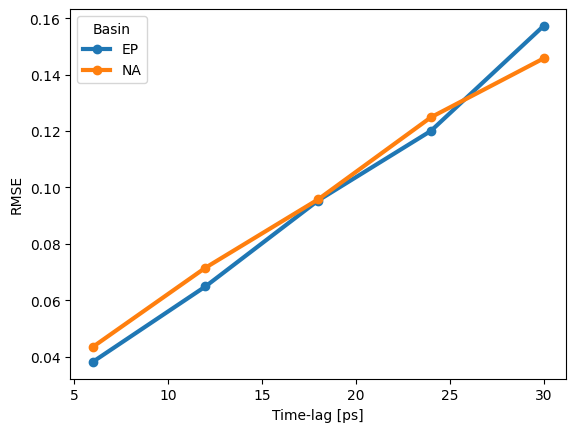

In [9]:
fig, ax = plt.subplots()
# fig.set_size_inches(16, 8)

for basin in basins:
    ax.plot(error_d[basin].keys(), error_d[basin].values(), lw=3, marker='o', label=basin)
ax.set_xlabel("Time-lag [ps]")
ax.set_ylabel("RMSE")
# ax.margins(x=0)
ax.legend(title="Basin")

Context length 8

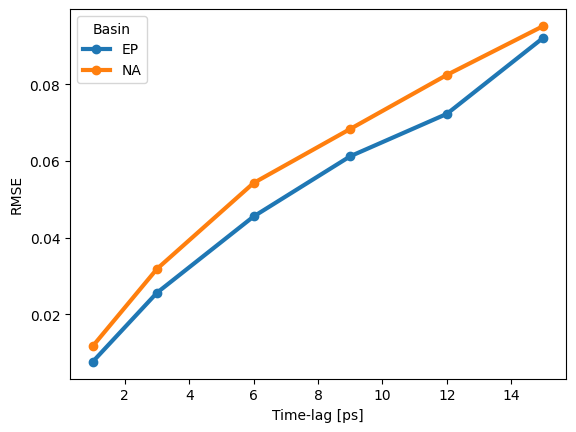

In [12]:
fig, ax = plt.subplots()
# fig.set_size_inches(16, 8)

for basin in basins:
    ax.plot(error_d[basin].keys(), error_d[basin].values(), lw=3, marker='o', label=basin)
ax.set_xlabel("Time-lag [ps]")
ax.set_ylabel("RMSE")
# ax.margins(x=0)
ax.legend(title="Basin")

Context length 2

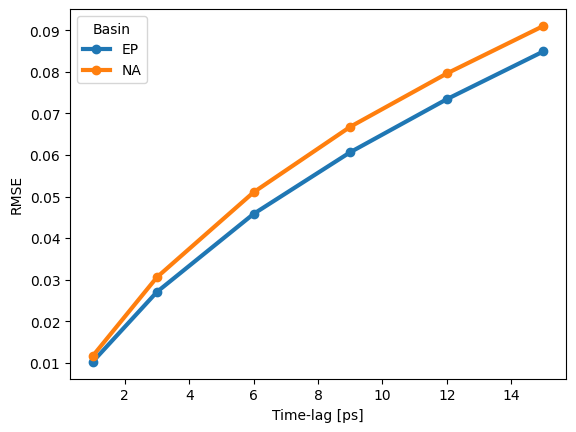

In [39]:
fig, ax = plt.subplots()
# fig.set_size_inches(16, 8)

for basin in basins:
    ax.plot(error_d[basin].keys(), error_d[basin].values(), lw=3, marker='o', label=basin)
ax.set_xlabel("Time-lag [ps]")
ax.set_ylabel("RMSE")
# ax.margins(x=0)
ax.legend(title="Basin")

In [13]:
from itertools import product

In [14]:
top_k

10

Context length 16

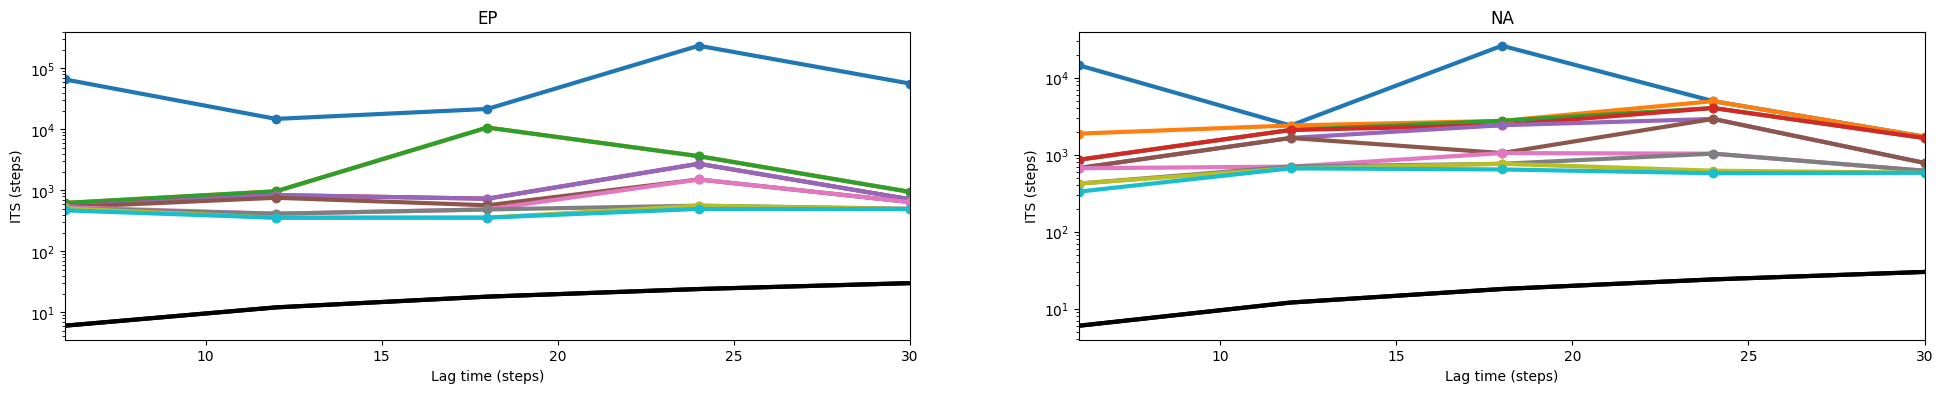

In [18]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]
start_idx = 0

for idx, basin in enumerate(basins):

    for idx_k in range(0, top_k):
        try:
            ax[idx].plot(time_lags[start_idx:], [tscale[idx_k] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
        except:
            print(idx, idx_k)
    # ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[4] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    ax[idx].set_yscale("log")

Context length 8

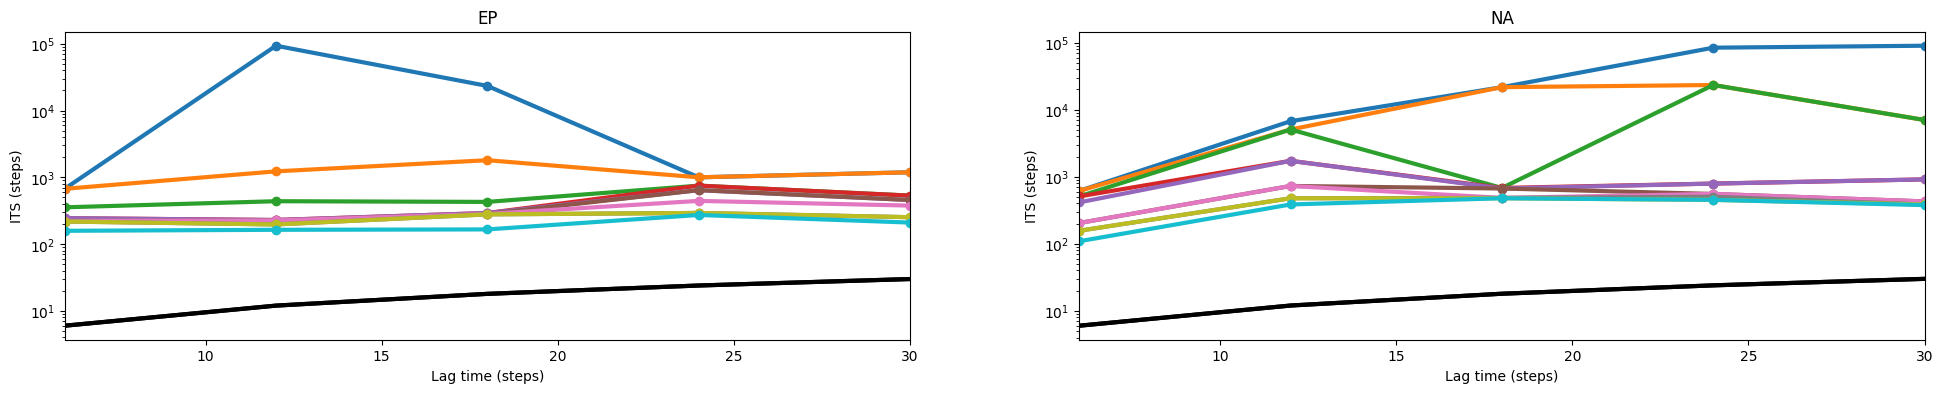

In [26]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]
start_idx = 0

for idx, basin in enumerate(basins):

    for idx_k in range(0, top_k):
        try:
            ax[idx].plot(time_lags[start_idx:], [tscale[idx_k] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
        except:
            print(idx, idx_k)
    # ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[4] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    ax[idx].set_yscale("log")

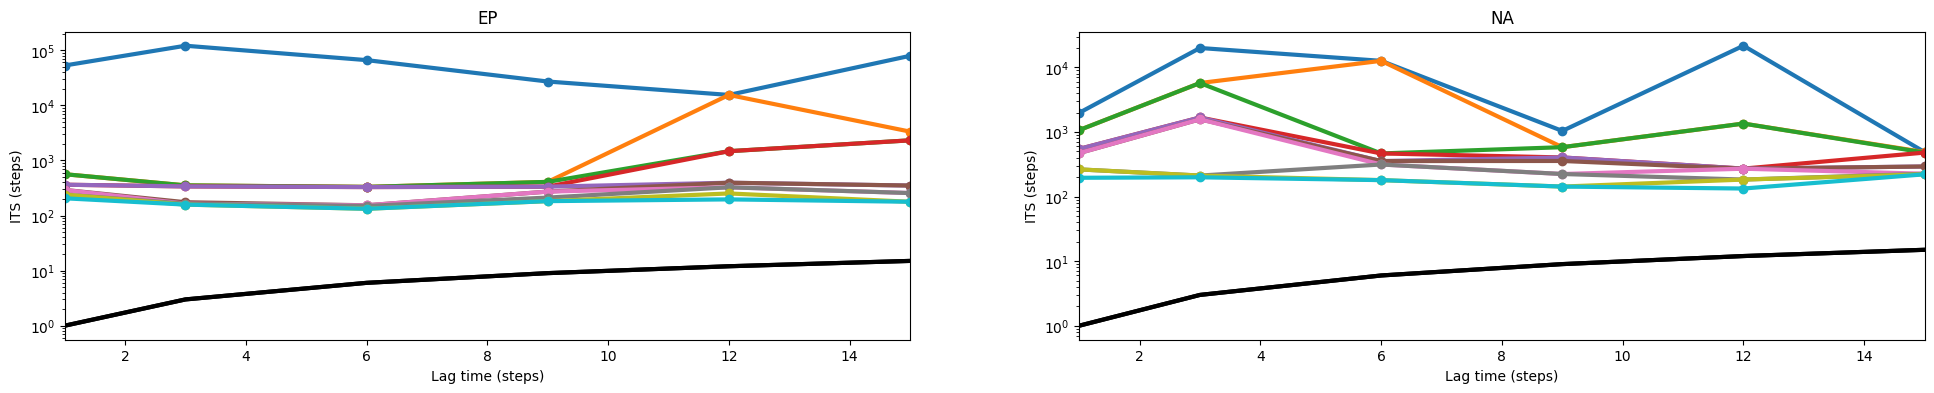

In [15]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]
start_idx = 0

for idx, basin in enumerate(basins):

    for idx_k in range(0, top_k):
        try:
            ax[idx].plot(time_lags[start_idx:], [tscale[idx_k] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
        except:
            print(idx, idx_k)
    # ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[4] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    ax[idx].set_yscale("log")

Context length 2

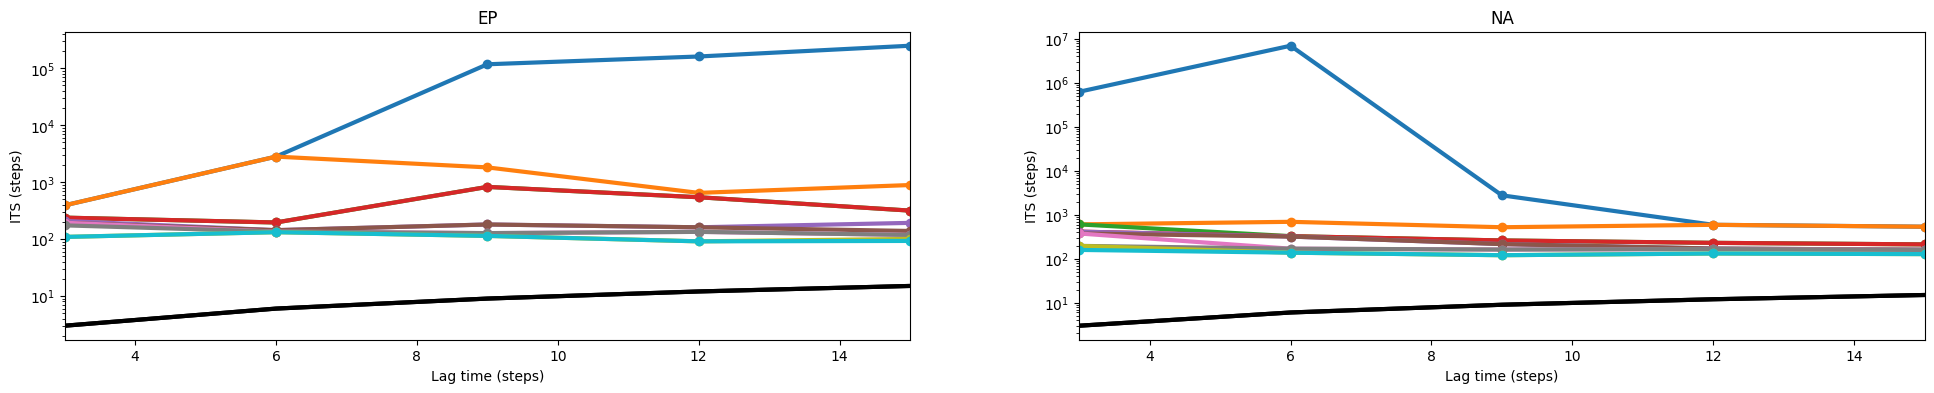

In [48]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

start_idx = 1

for idx, basin in enumerate(basins):

    for idx_k in range(0, top_k):
        try:
            ax[idx].plot(time_lags[start_idx:], [tscale[idx_k] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
        except:
            print(idx, idx_k)
    # ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[4] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    ax[idx].set_yscale("log")

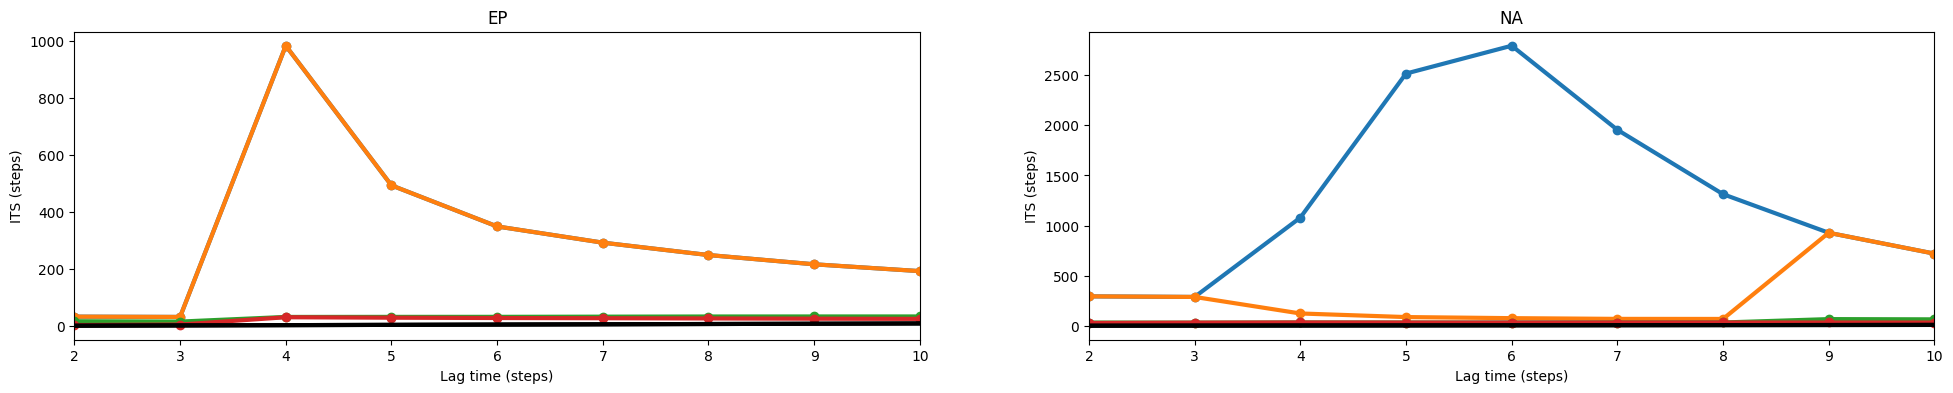

In [46]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]
start_idx = 1

for idx, basin in enumerate(basins):

    for idx_k in range(1, top_k):
        ax[idx].plot(time_lags[start_idx:], [tscale[idx_k] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[4] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

### Old plots

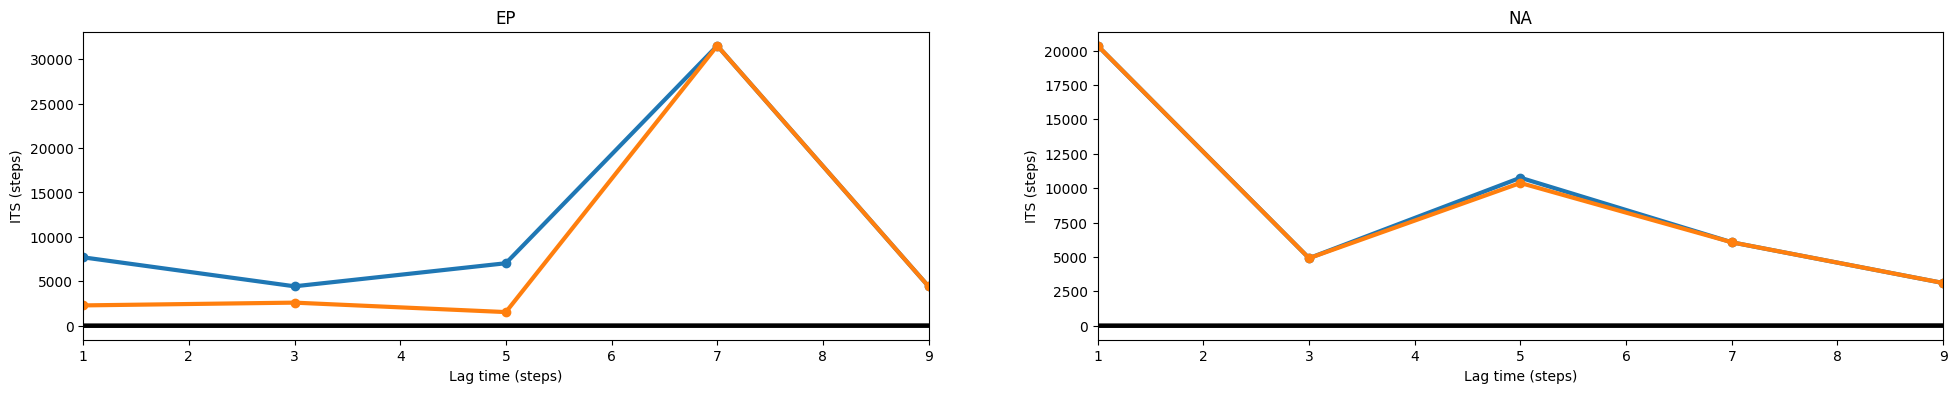

In [247]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]
start_idx = 0

for idx, basin in enumerate(basins):

    # ax[idx].plot(time_lags[start_idx:], [tscale[0] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

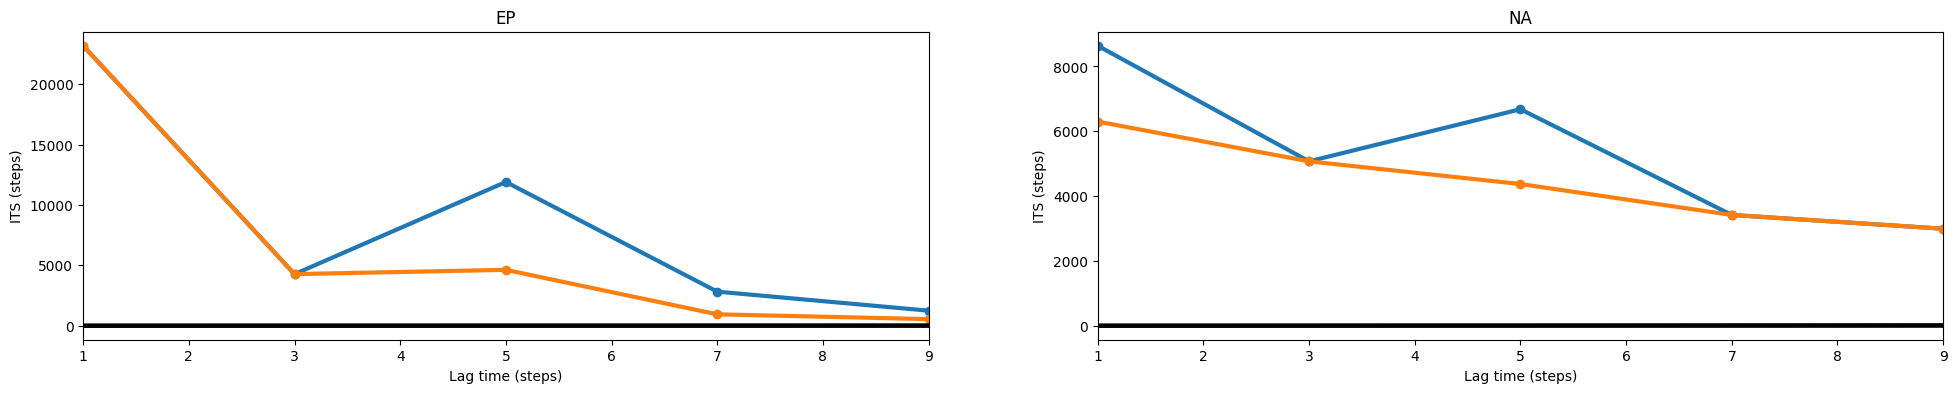

In [198]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]

for idx, basin in enumerate(basins):

    # ax[idx].plot(time_lags, [tscale[0] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[1] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[2] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    # ax[idx].plot(time_lags, [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags, time_lags, lw=3, c='k')
    ax[idx].plot(time_lags, time_lags, lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

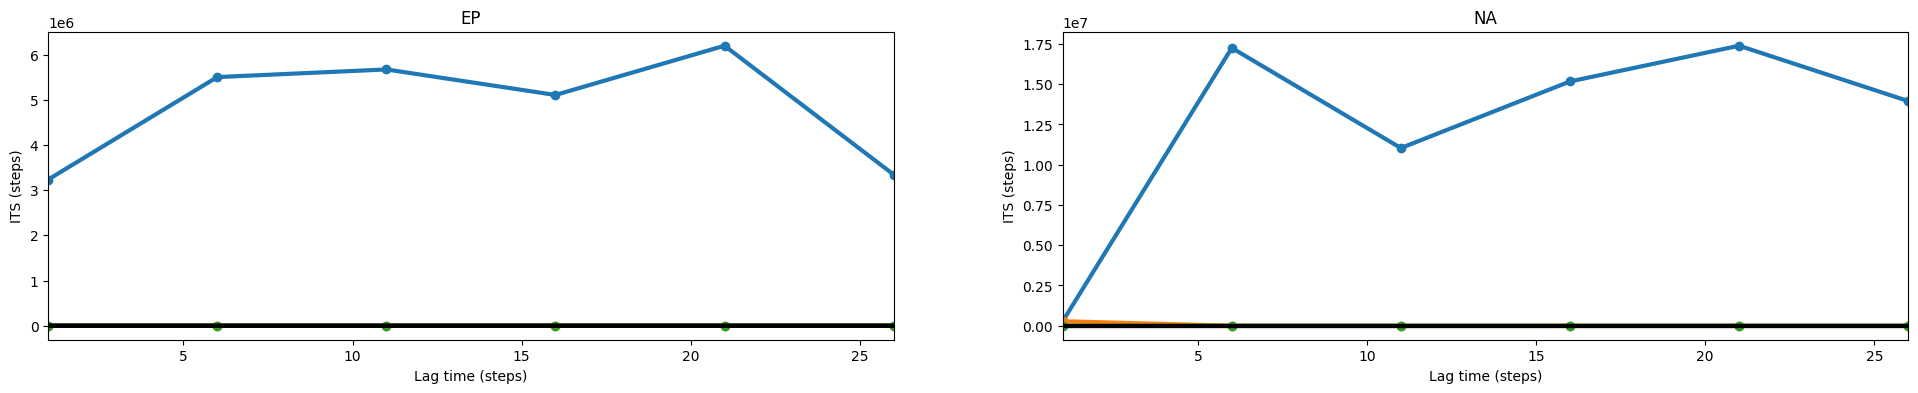

In [54]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]

for idx, basin in enumerate(basins):

    ax[idx].plot(time_lags, [tscale[0] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[1] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[2] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    # ax[idx].plot(time_lags, [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags, time_lags, lw=3, c='k')
    ax[idx].plot(time_lags, time_lags, lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

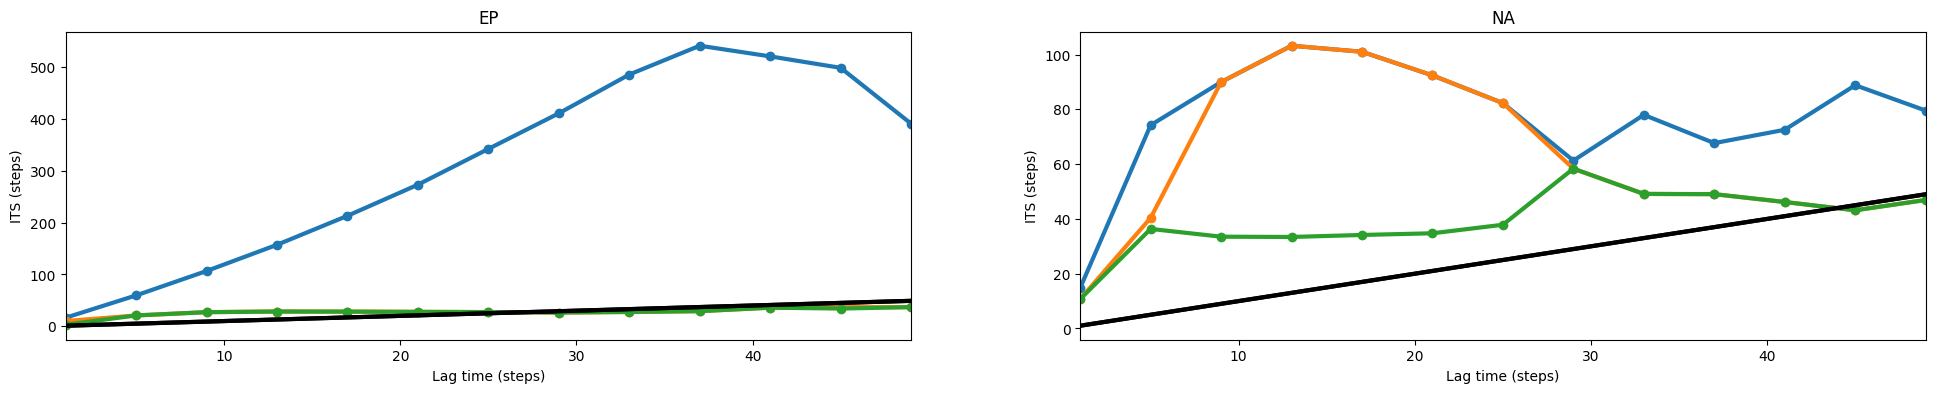

In [24]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]

for idx, basin in enumerate(basins):

    ax[idx].plot(time_lags, [tscale[1] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[2] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags, time_lags, lw=3, c='k')
    ax[idx].plot(time_lags, time_lags, lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

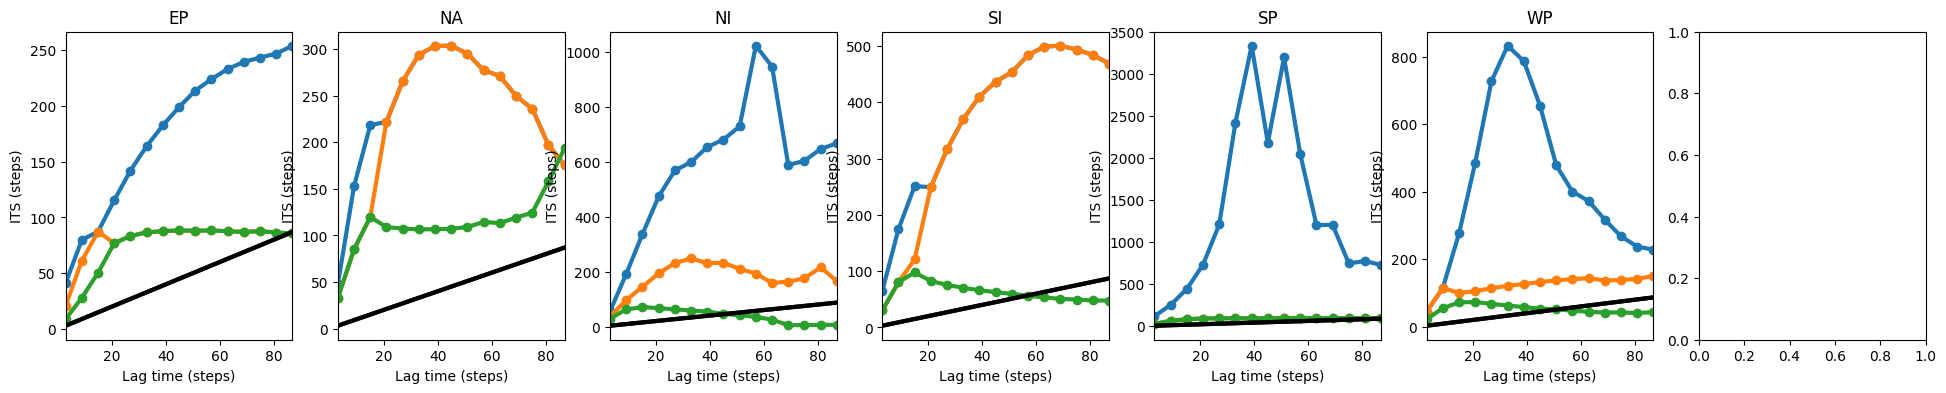

In [112]:
fig, ax = plt.subplots(ncols=len(BASINS), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = BASINS[1]

for idx, basin in enumerate(BASINS[:-1]):

    ax[idx].plot(time_lags, [tscale[1] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[2] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags, time_lags, lw=3, c='k')
    ax[idx].plot(time_lags, time_lags, lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

In [ ]:
a = None

In [21]:
len(time_lags)

15

EP
NA
NI
SI
SP
WP


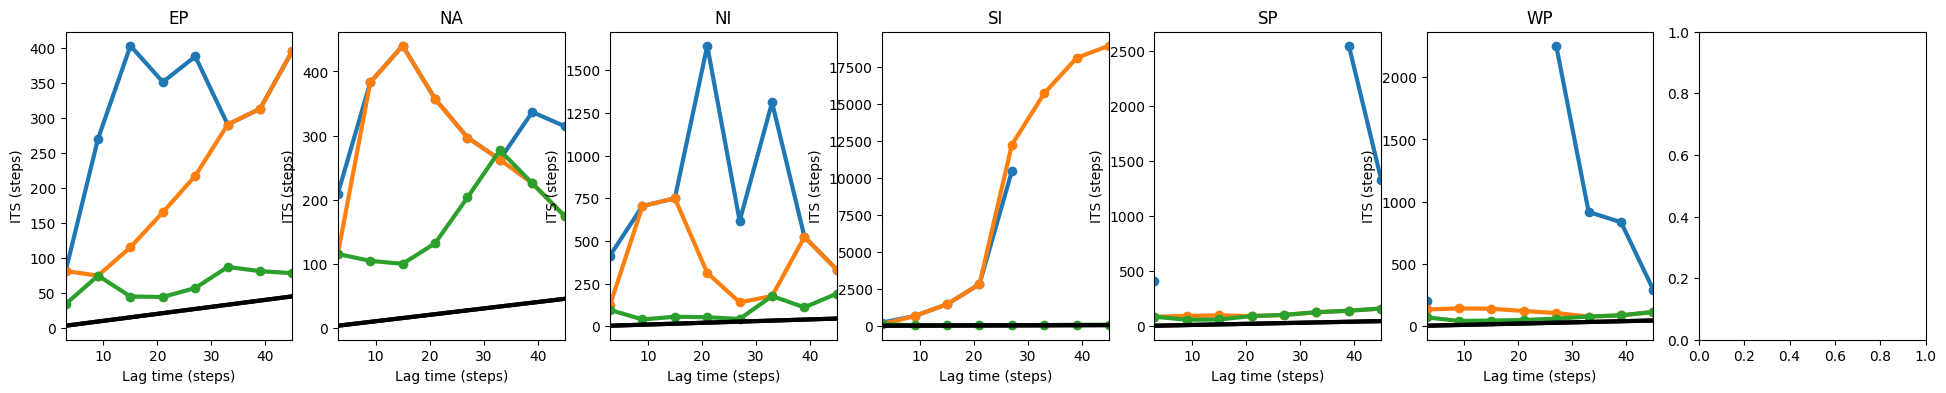

In [26]:
fig, ax = plt.subplots(ncols=len(BASINS), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = BASINS[1]

max_time_lag_idx = 8
for idx, basin in enumerate(BASINS[:-1]):

    print(basin)
    ax[idx].plot(time_lags[:max_time_lag_idx], [tscale[1] for tscale in list(tscale_d[basin].values())[:max_time_lag_idx]], lw=3, marker='o')
    ax[idx].plot(time_lags[:max_time_lag_idx], [tscale[2] for tscale in list(tscale_d[basin].values())[:max_time_lag_idx]], lw=3, marker='o')
    ax[idx].plot(time_lags[:max_time_lag_idx], [tscale[3] for tscale in list(tscale_d[basin].values())[:max_time_lag_idx]], lw=3, marker='o')

    ax[idx].plot(time_lags[:max_time_lag_idx], time_lags[:max_time_lag_idx], lw=3, c='k')
    ax[idx].plot(time_lags[:max_time_lag_idx], time_lags[:max_time_lag_idx], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

### Slide-by scaling

In [ ]:
evals_d = {}
error_d = {}
tscale_d = {}

slide_bys = range(1, 6)
# slide_bys = range(1, 10, 2)
# slide_bys = range(1, 30, 5)
# slide_bys = [1, 5, 10]

time_lags = slide_bys
for basin in basins:
    ev_d, e_d, ts_d = slide_by_scaling(tc_tracks_dict[basin], slide_bys=slide_bys, context_length=context_length, top_k=top_k, model_config=model_config, feature_list=feature_list)
    evals_d[basin] = ev_d
    error_d[basin] = e_d
    tscale_d[basin] = ts_d


Train with slide_by 1.
Train with slide_by 2.
Train with slide_by 3.
Train with slide_by 4.
Train with slide_by 5.


RMSE error as a function of the time-lag. The basin is given in the legend.

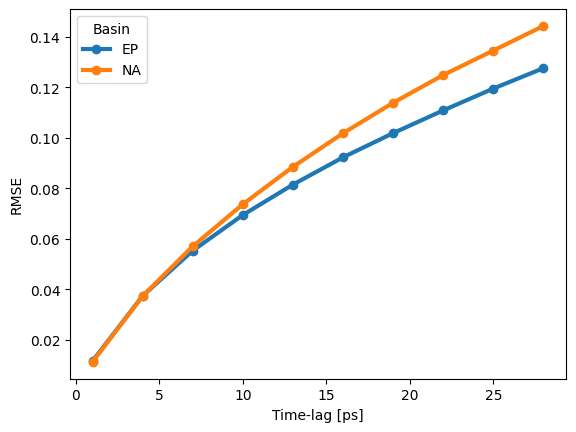

In [ ]:
fig, ax = plt.subplots()
# fig.set_size_inches(16, 8)

for basin in basins:
    ax.plot(error_d[basin].keys(), error_d[basin].values(), lw=3, marker='o', label=basin)
ax.set_xlabel("Time-lag [ps]")
ax.set_ylabel("RMSE")
# ax.margins(x=0)
ax.legend(title="Basin")

In [ ]:
from itertools import product

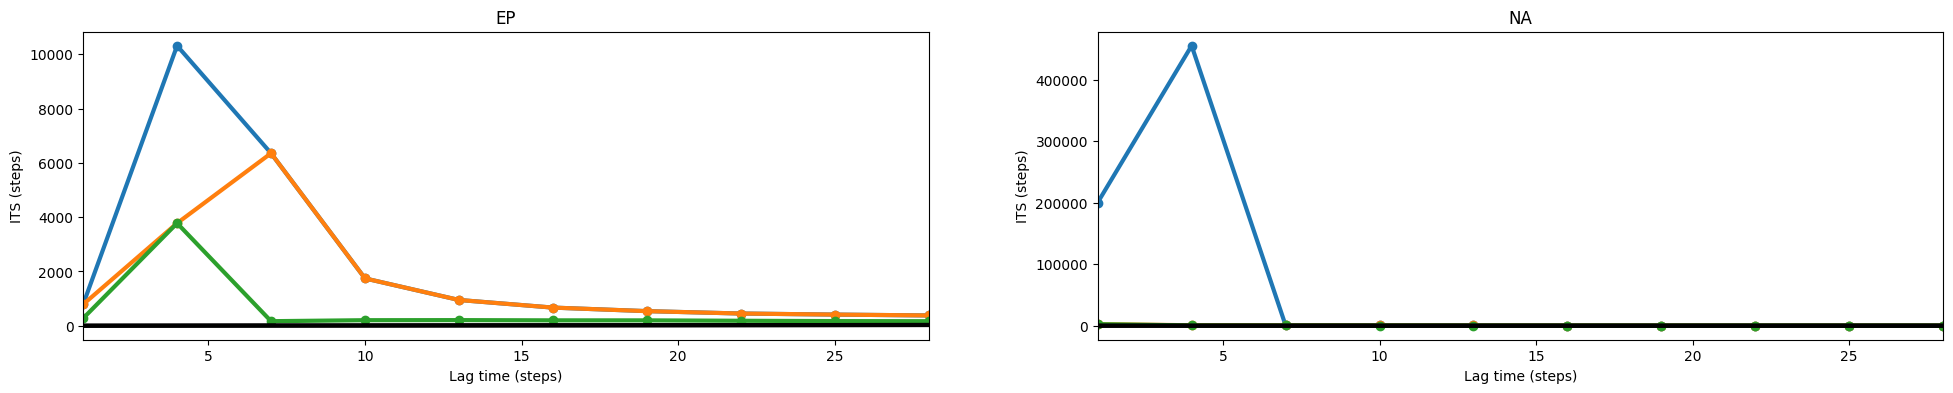

In [ ]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]
start_idx = 0

for idx, basin in enumerate(basins):

    ax[idx].plot(time_lags[start_idx:], [tscale[0] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

## Imported Data

In [11]:
import os
import pickle
import numpy as np

from klearn_tcyclone.climada.tc_tracks_tools import BASINS
from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.kooplearn.spectral_analysis import (
    time_lag_scaling,
)

from itertools import product

In [12]:
def load_data(time_step_h, year_range, num_centers, context_lengths, time_lags):
    model_config = {
        "length_scale": 10.0,
        "reduced_rank": True,
        # "reduced_rank": False,
        "rank": 50,
        "num_centers": num_centers,
        "tikhonov_reg": 1e-8,
        "svd_solver": "arnoldi",
        "rng_seed": 42,
    }

    folder_name = "_".join(
        [
            "year_range",
            *map(str, year_range),
            "clengths",
            *map(str, context_lengths),
            "tlags",
            *map(str, time_lags),
        ]
    )
    load_path = os.path.join(
        "../data/", "koopman_spectral_analysis/", "time_lag_scaling/", folder_name
    )

    evals = {}
    errors = {}
    time_scales = {}
    for context_length in context_lengths:
        print("Load data for context length:", context_length)

        if model_config["reduced_rank"]:
            reduced_rank_str = "redrank"
        else:
            reduced_rank_str = ""
        file_name = "_".join(
            [
                f"cl{context_length}",
                f"tsteph{time_step_h}"
                f"nc{model_config['num_centers']}",
                f"tkreg{model_config['tikhonov_reg']}",
                reduced_rank_str,
            ]
        )

        with open(os.path.join(load_path, "evals_" + file_name + ".pickle"), "rb") as file:
            evals[context_length] = pickle.load(file)
        with open(os.path.join(load_path, "errors_" + file_name + ".pickle"), "rb") as file:
            errors[context_length] = pickle.load(file)
        with open(
            os.path.join(load_path, "time_scales_" + file_name + ".pickle"), "rb"
        ) as file:
            time_scales[context_length] = pickle.load(file)

    return evals, errors, time_scales


In [13]:
# BASINS = ["EP", "NA", "NI", "SI", "SP", "WP", "SA"]
basins = ["EP", "NA", "SI", "SP", "WP"]
# basins = BASINS[:-1]

top_k = 20
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    "radius_max_wind",
    "radius_oci",
    "central_pressure",
    "environmental_pressure",
]

### Year range (1980, 2021)

Likely best choise: Window from 1980 to 2021, with 800 centers and context length of 4 or 8. Both have reasonable eigenvalue distributions and time lag scaling.

Best time lag scaling for context length is 2 or 4. 4 gives slightly better RMSE. Best eigenvalue distribution for context length 8 or 16, with weakest "overshoot" over theoretical maximum of 1.

#### Num centers 800

In [14]:
year_range = (1980, 2021)
context_lengths = [2, 4, 8, 16]
num_centers = 800

In [17]:
# time_step_h = 1.0
# time_step_scaling = int(3 / time_step_h)
# time_lags = [1, *list(np.array(range(1, 6, 1)) * time_step_scaling)]
# evals, errors, time_scales = load_data(time_step_h, year_range, num_centers, context_lengths, time_lags)

time_step_h = 0.5
time_step_scaling = int(3 / time_step_h)
time_lags_05 = [1, *list(np.array(range(1, 6, 1)) * time_step_scaling)]
evals_05, errors_05, time_scales_05 = load_data(time_step_h, year_range, num_centers, context_lengths, time_lags_05)

Load data for context length: 2
Load data for context length: 4
Load data for context length: 8
Load data for context length: 16


In [21]:
time_scales_05.keys()

dict_keys([2, 4, 8, 16])

C:\Users\Eric\AppData\Local\Temp\ipykernel_20124\2132191804.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


Text(0, 0.5, 'RMSE')

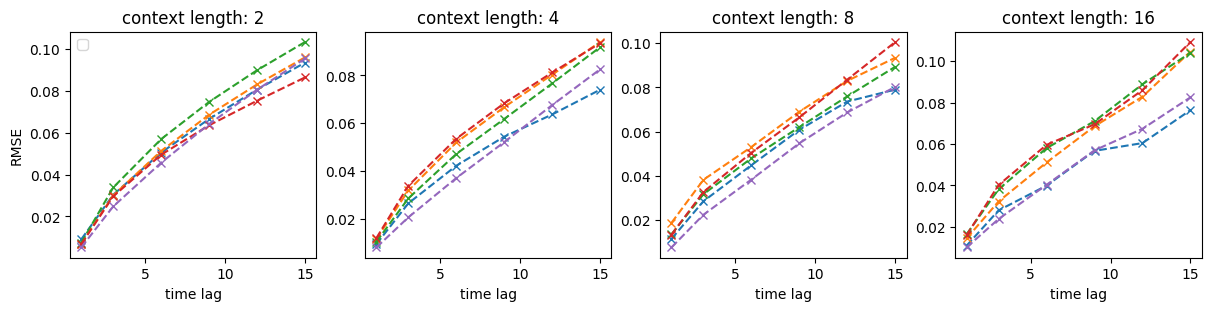

In [18]:
fig, ax = plt.subplots(nrows=1, ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,3)

for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    # ax[idx_cl].plot(time_lags, errors[context_length][basin].values(), color=f"C{idx_b}", marker="x", label=f"basin={basin}")
    ax[idx_cl].plot(time_lags, errors_05[context_length][basin].values(), color=f"C{idx_b}", marker="x", linestyle="dashed")
    ax[idx_cl].set_title(f"context length: {context_length}")
    ax[idx_cl].set_xlabel("time lag")
ax[0].legend()
ax[0].set_ylabel("RMSE")

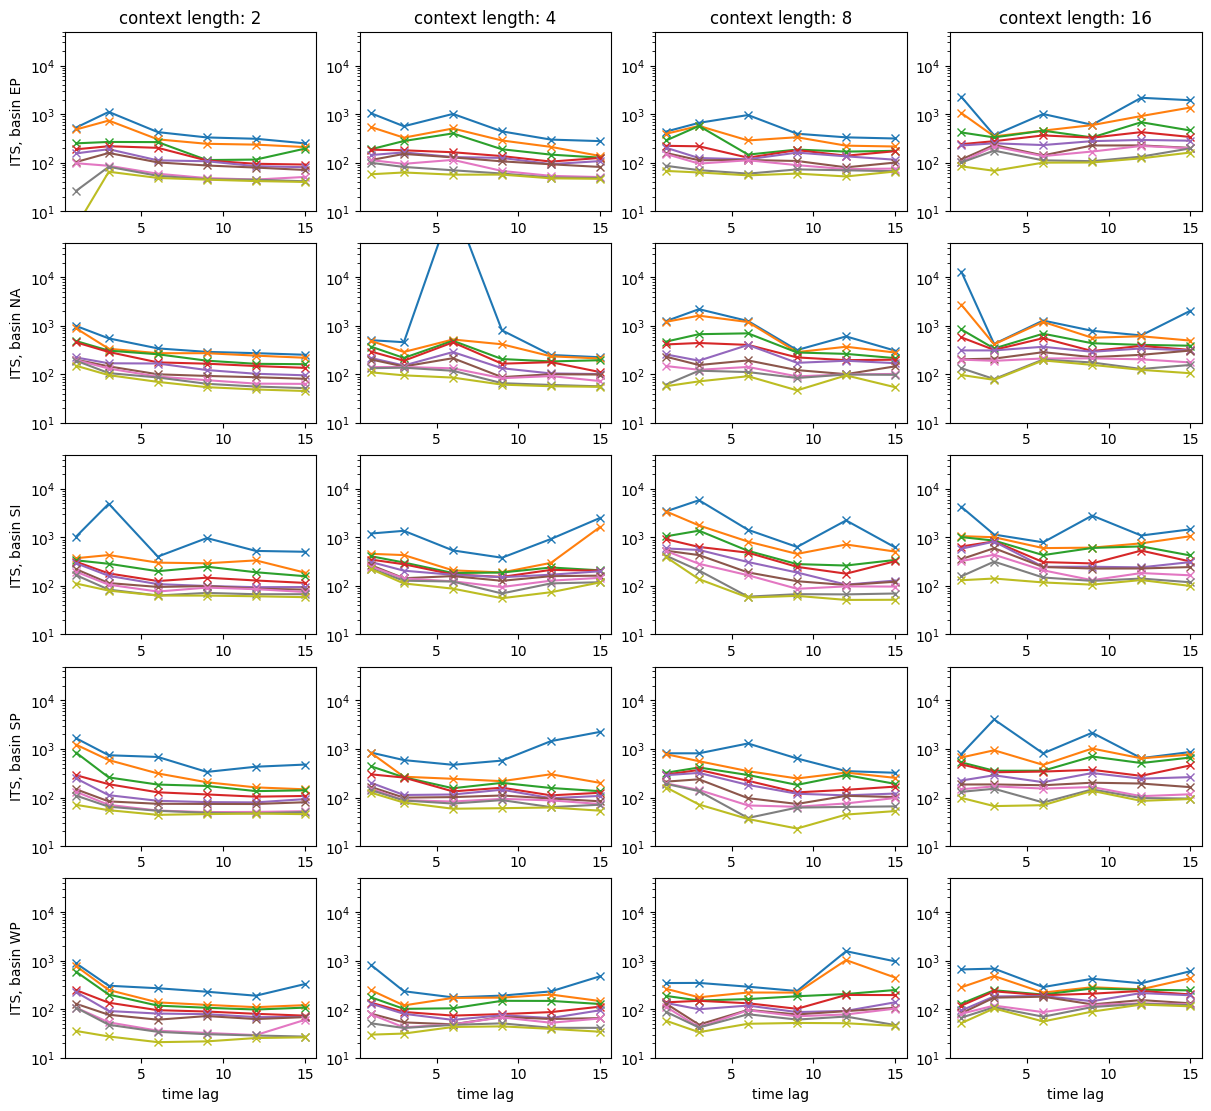

In [ ]:
fig, ax = plt.subplots(nrows=len(basins), ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,11)

eval_range = range(2, 19, 2)
# eval_range = [1, 2, 3, 5, 8]
for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    for idx_eval_c, idx_eval in enumerate(eval_range):
        # ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", label=idx_eval)
        ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales_05[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", linestyle="dashed")
    if idx_b == 0:
        ax[idx_b, idx_cl].set_title(f"context length: {context_length}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_cl].set_xlabel("time lag")
    ax[idx_b, idx_cl].set_yscale("log")
    ax[idx_b, idx_cl].set_ylim(1E1, 5E4)
    # ax[idx_b, idx_cl].set_ylim(9E1, 2E6)
    # ax[idx_b, 0].legend(title="eval index")
    ax[idx_b, 0].set_ylabel(f"ITS, basin {basin}")

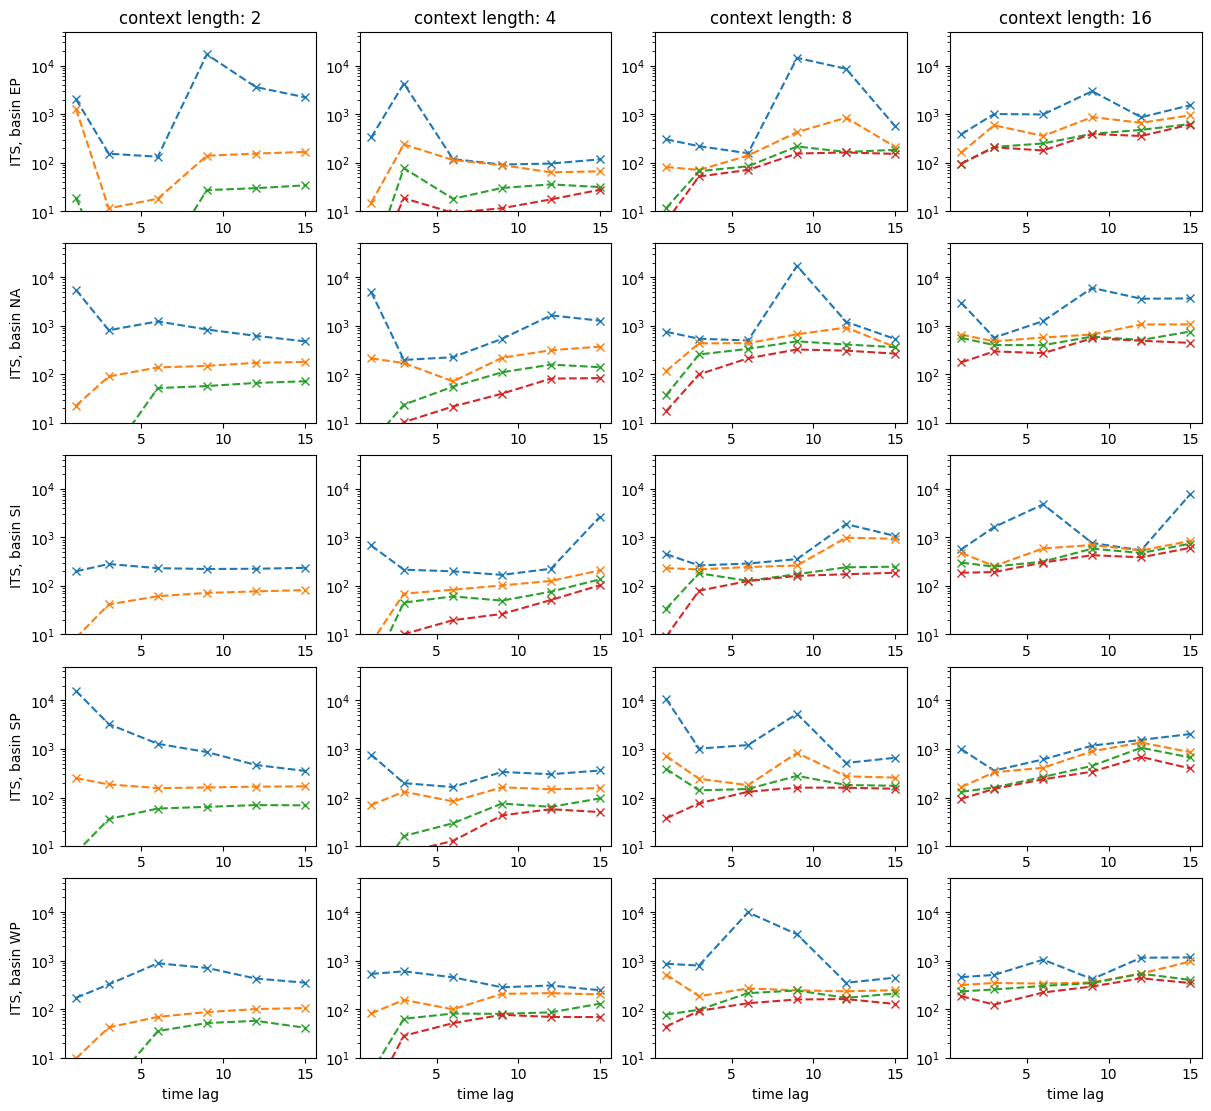

In [23]:
fig, ax = plt.subplots(nrows=len(basins), ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,11)

eval_range = range(2, 10, 2)
# eval_range = range(2, 19, 2)
# eval_range = [1, 2, 3, 5, 8]
for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    for idx_eval_c, idx_eval in enumerate(eval_range):
        # ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", label=idx_eval)
        ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales_05[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", linestyle="dashed")
    if idx_b == 0:
        ax[idx_b, idx_cl].set_title(f"context length: {context_length}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_cl].set_xlabel("time lag")
    ax[idx_b, idx_cl].set_yscale("log")
    ax[idx_b, idx_cl].set_ylim(1E1, 5E4)
    # ax[idx_b, idx_cl].set_ylim(9E1, 2E6)
    # ax[idx_b, 0].legend(title="eval index")
    ax[idx_b, 0].set_ylabel(f"ITS, basin {basin}")

##### Plotting eigenvalues

In [67]:
# fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
# fig.set_size_inches(15, 9)

# # context_length = 2
# for idx_cl, context_length in enumerate(context_lengths):

#     for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
#         ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".", color=f"C{idx_cl}", markersize=2)
#         if idx_tl == 0:
#             ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
#         if idx_b == 0:
#             ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
#         if idx_b == len(basins) - 1:
#             ax[idx_b, idx_tl].set_xlabel("real")
#         ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


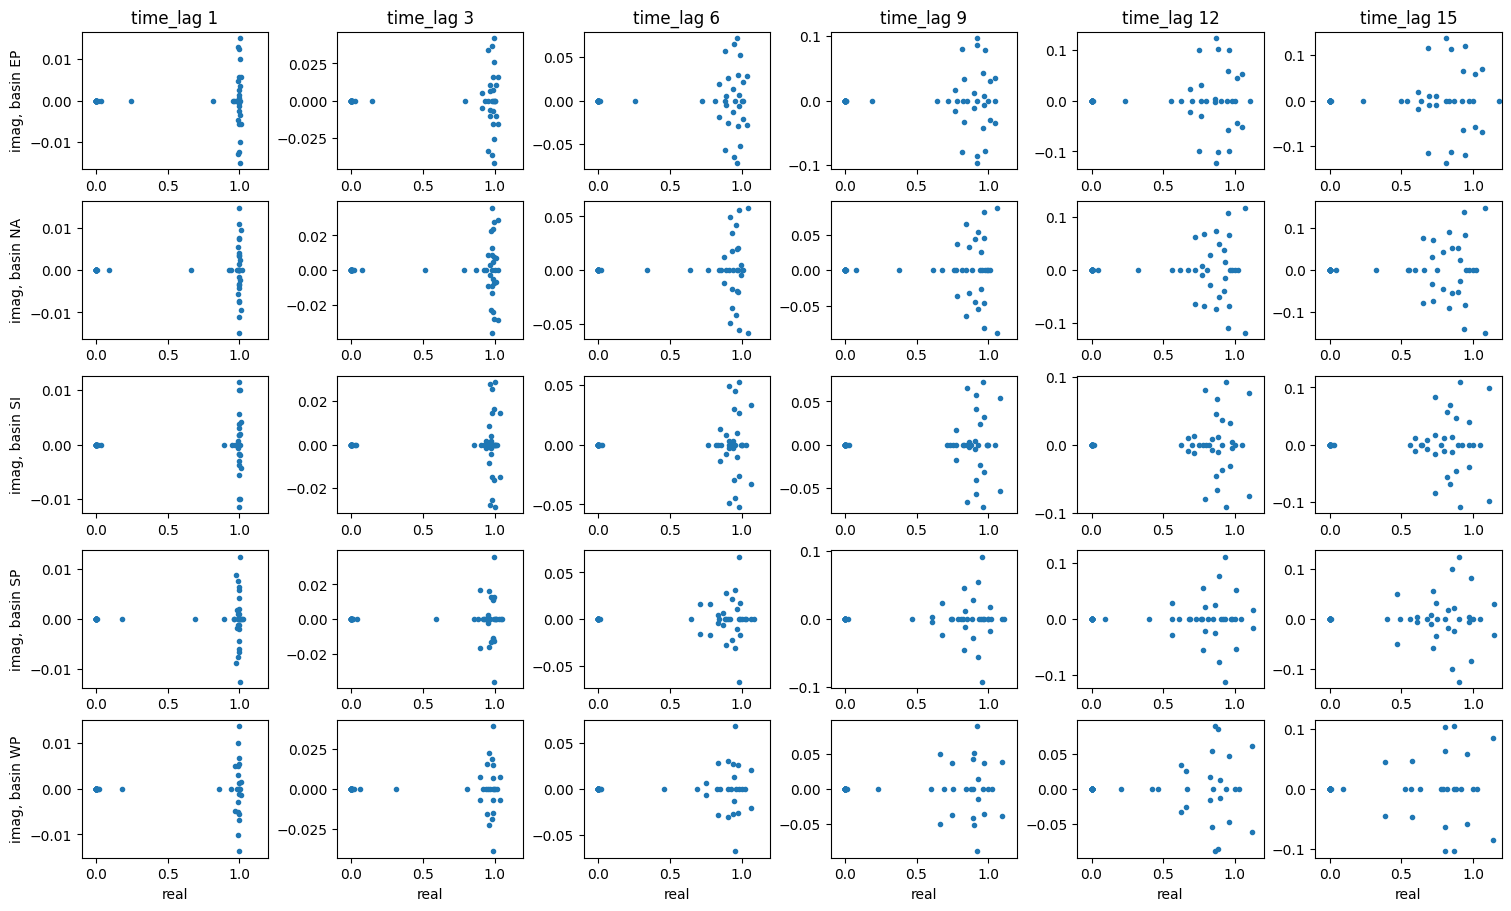

In [68]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 2

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


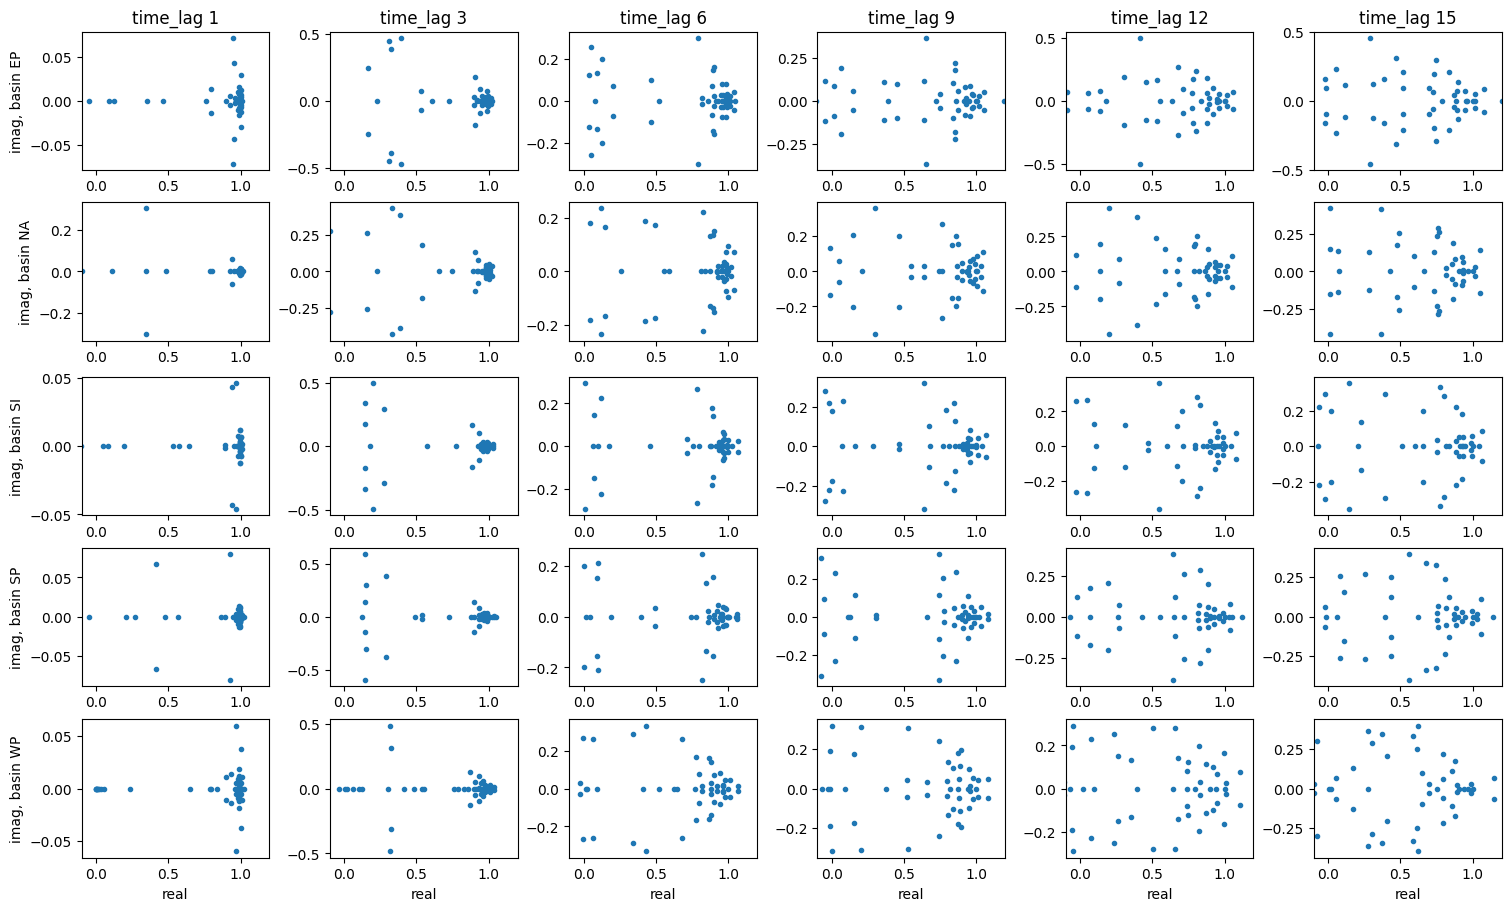

In [69]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 4

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


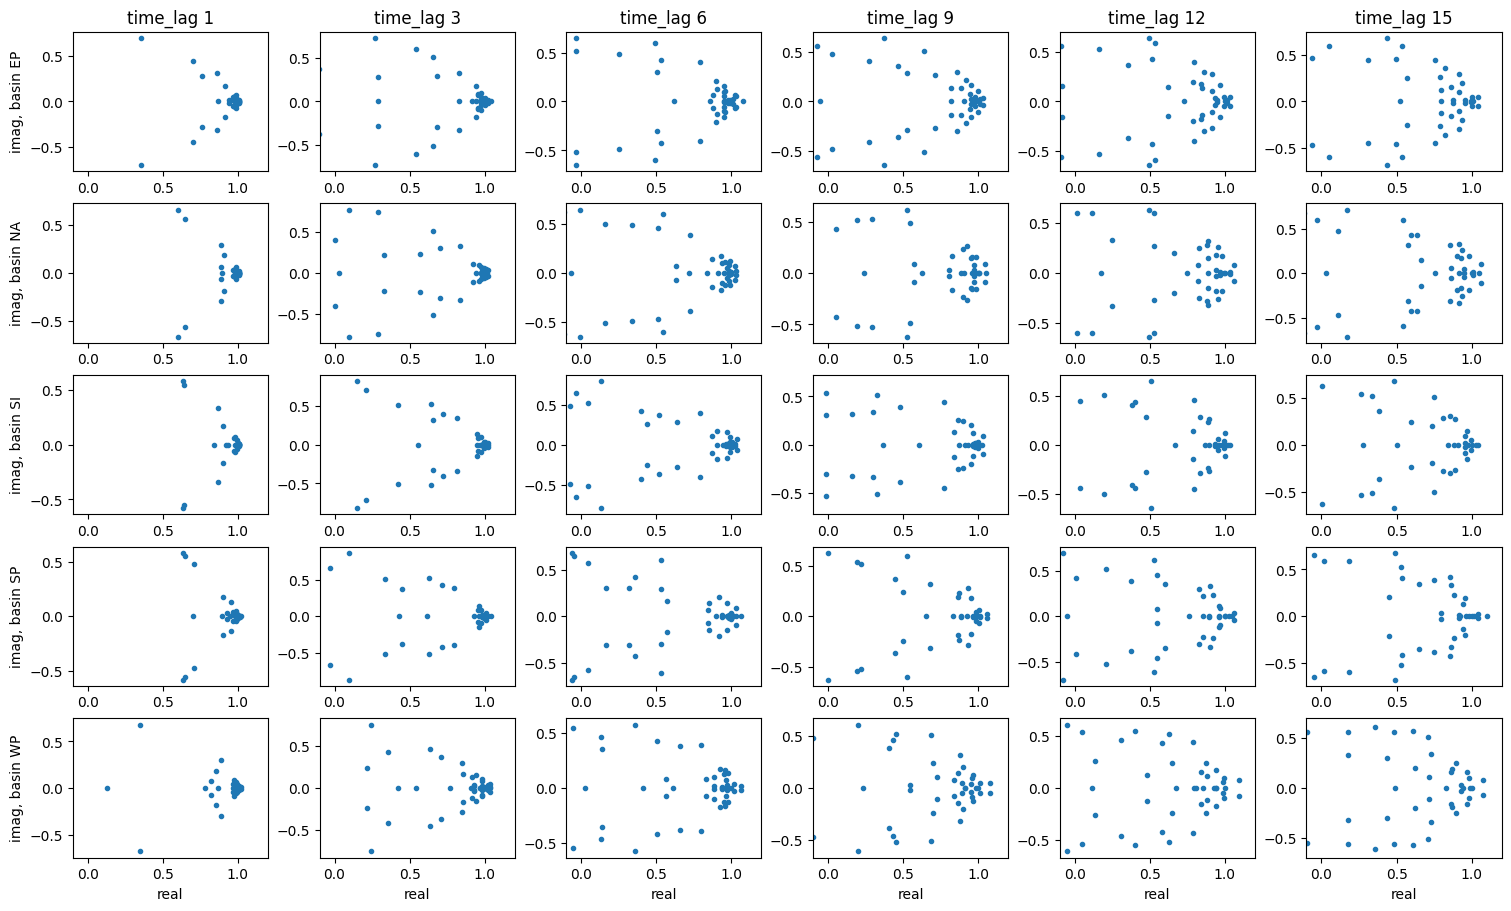

In [70]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 8

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


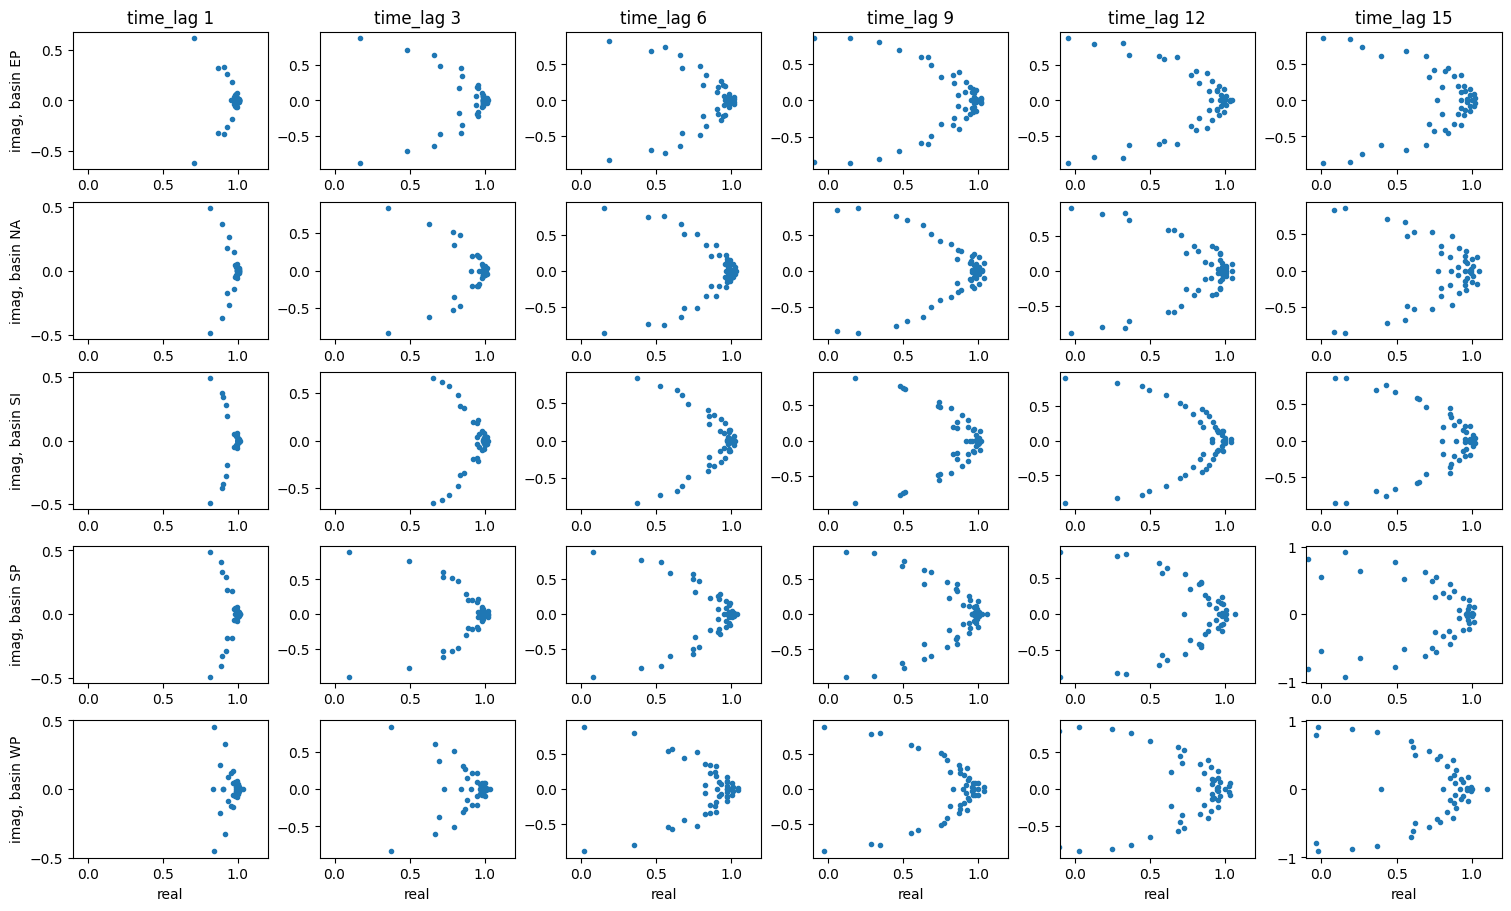

In [71]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 16

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


#### Num centers 1600

In [88]:
year_range = (1980, 2021)
context_lengths = [2, 4, 8, 16]
num_centers = 1600

In [89]:
time_step_h = 1.0
time_step_scaling = int(3 / time_step_h)
time_lags = [1, *list(np.array(range(1, 6, 1)) * time_step_scaling)]
evals, errors, time_scales = load_data(time_step_h, year_range, num_centers, context_lengths, time_lags)

time_step_h = 0.5
time_step_scaling = int(3 / time_step_h)
time_lags_05 = [1, *list(np.array(range(1, 6, 1)) * time_step_scaling)]
evals_05, errors_05, time_scales_05 = load_data(time_step_h, year_range, num_centers, context_lengths, time_lags_05)

Load data for context length: 2
Load data for context length: 4
Load data for context length: 8
Load data for context length: 16
Load data for context length: 2
Load data for context length: 4
Load data for context length: 8
Load data for context length: 16


Text(0, 0.5, 'RMSE')

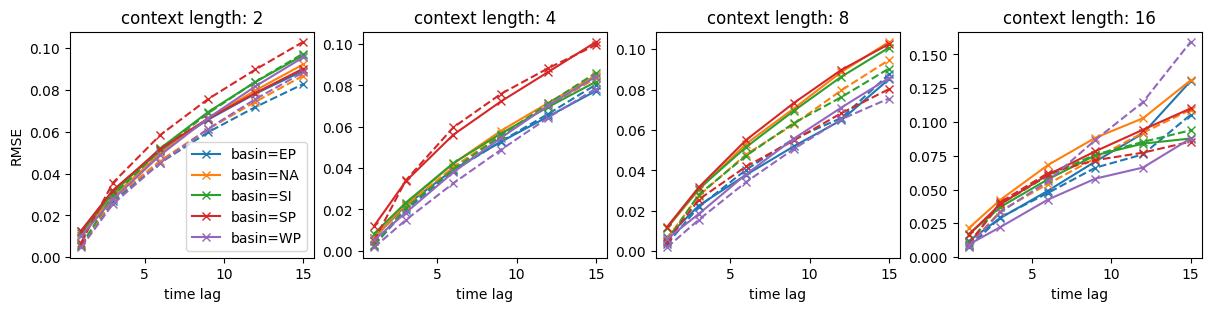

In [90]:
fig, ax = plt.subplots(nrows=1, ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,3)

for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    ax[idx_cl].plot(time_lags, errors[context_length][basin].values(), color=f"C{idx_b}", marker="x", label=f"basin={basin}")
    ax[idx_cl].plot(time_lags, errors_05[context_length][basin].values(), color=f"C{idx_b}", marker="x", linestyle="dashed")
    ax[idx_cl].set_title(f"context length: {context_length}")
    ax[idx_cl].set_xlabel("time lag")
ax[0].legend()
ax[0].set_ylabel("RMSE")

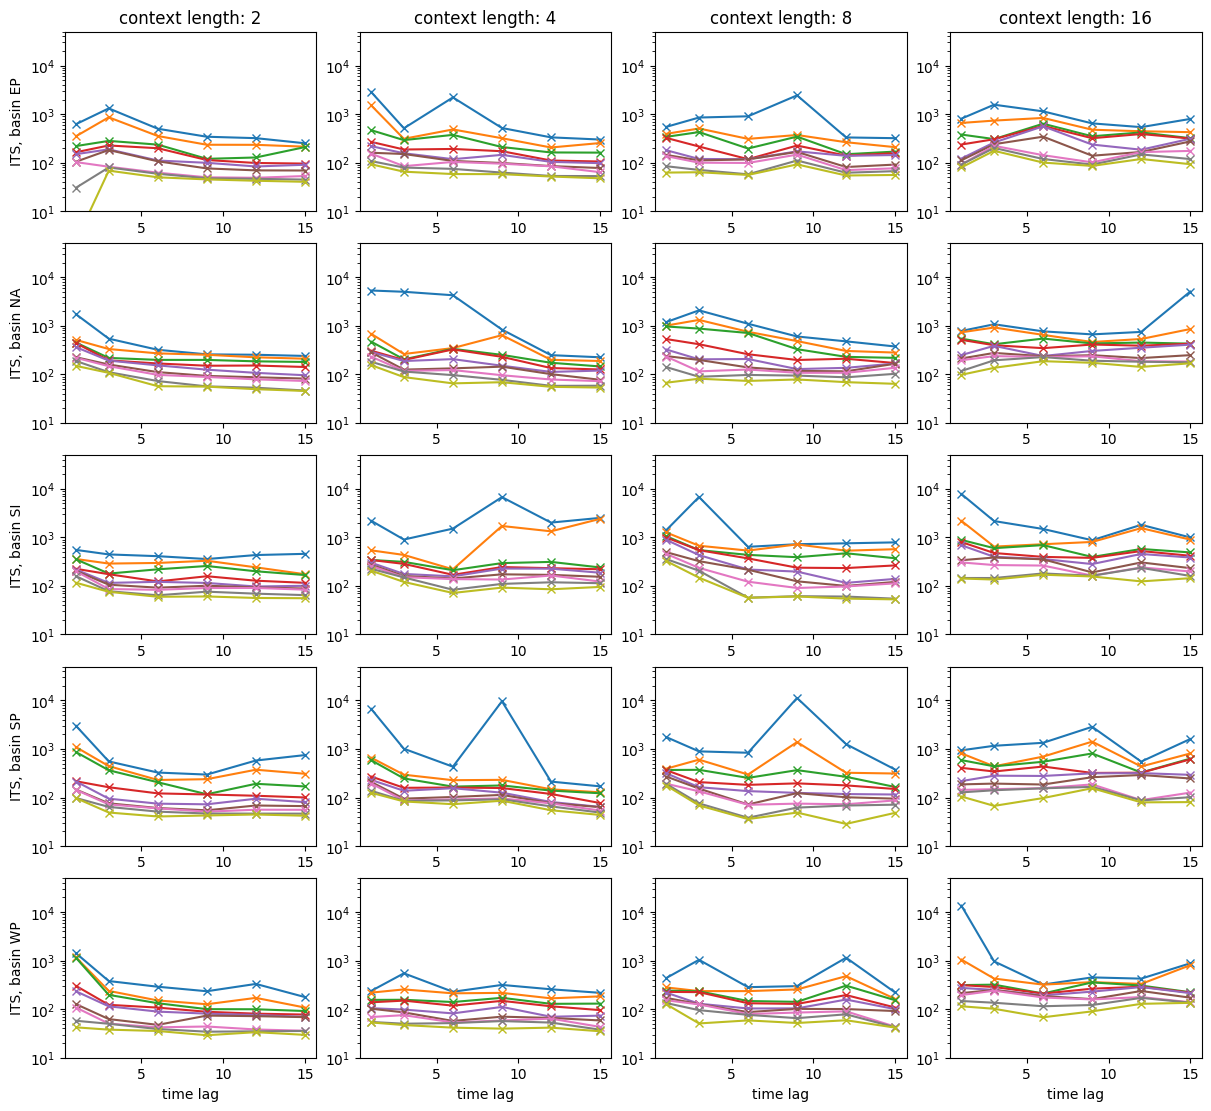

In [91]:
fig, ax = plt.subplots(nrows=len(basins), ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,11)

eval_range = range(2, 19, 2)
# eval_range = [1, 2, 3, 5, 8]
for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    for idx_eval_c, idx_eval in enumerate(eval_range):
        ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", label=idx_eval)
        # ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales_05[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", linestyle="dashed")
    if idx_b == 0:
        ax[idx_b, idx_cl].set_title(f"context length: {context_length}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_cl].set_xlabel("time lag")
    ax[idx_b, idx_cl].set_yscale("log")
    ax[idx_b, idx_cl].set_ylim(1E1, 5E4)
    # ax[idx_b, idx_cl].set_ylim(9E1, 2E6)
    # ax[idx_b, 0].legend(title="eval index")
    ax[idx_b, 0].set_ylabel(f"ITS, basin {basin}")


##### Plotting eigenvalues

In [74]:
# fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
# fig.set_size_inches(15, 9)

# # context_length = 2
# for idx_cl, context_length in enumerate(context_lengths):

#     for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
#         ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".", color=f"C{idx_cl}", markersize=2)
#         if idx_tl == 0:
#             ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
#         if idx_b == 0:
#             ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
#         if idx_b == len(basins) - 1:
#             ax[idx_b, idx_tl].set_xlabel("real")
#         ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


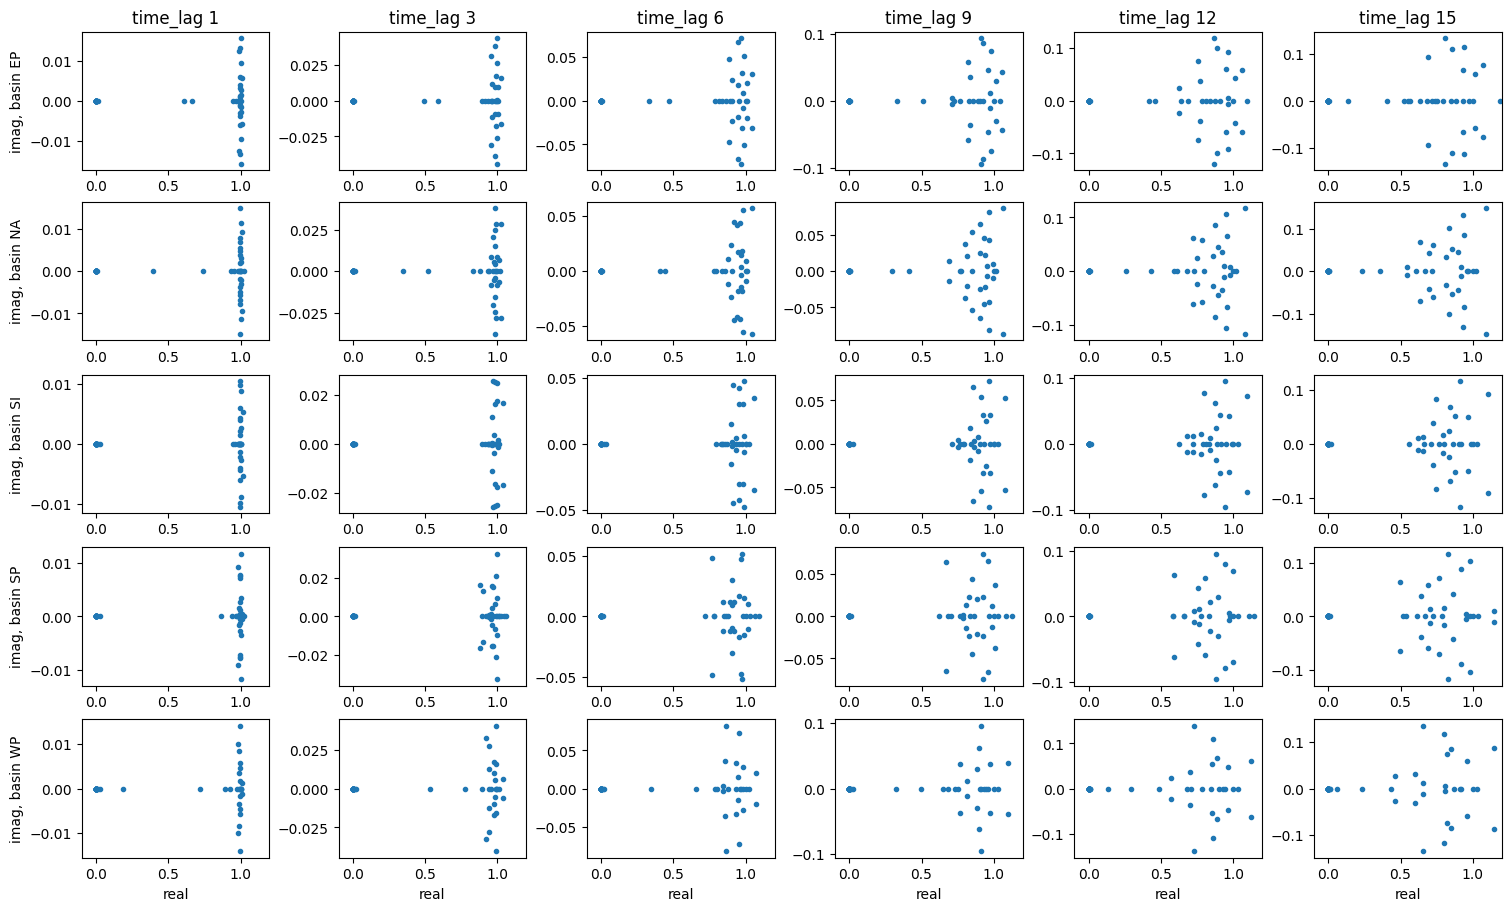

In [75]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 2

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


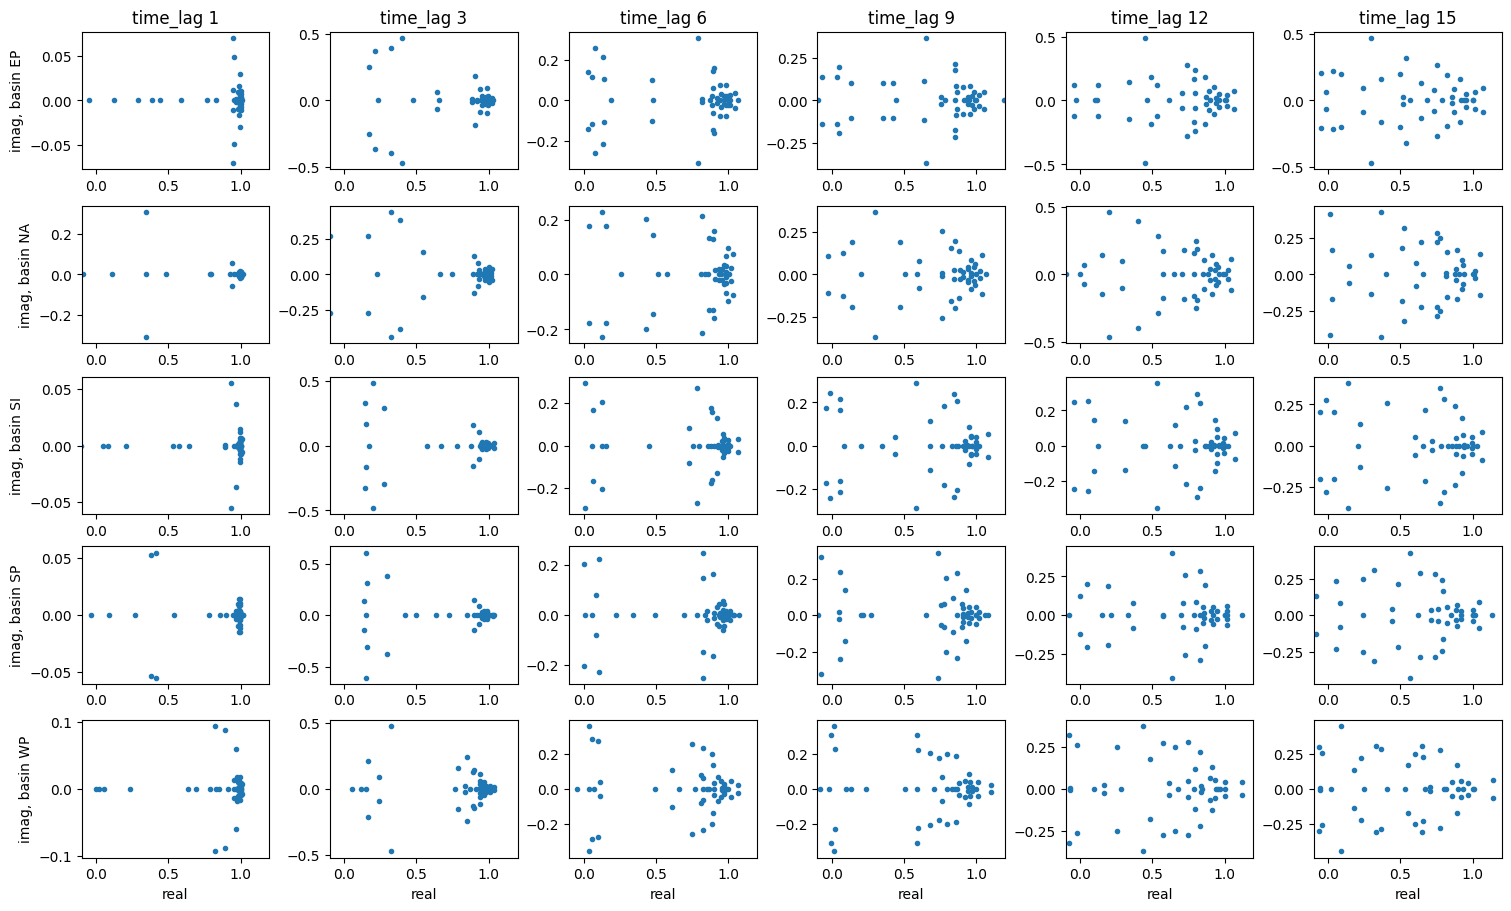

In [76]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 4

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


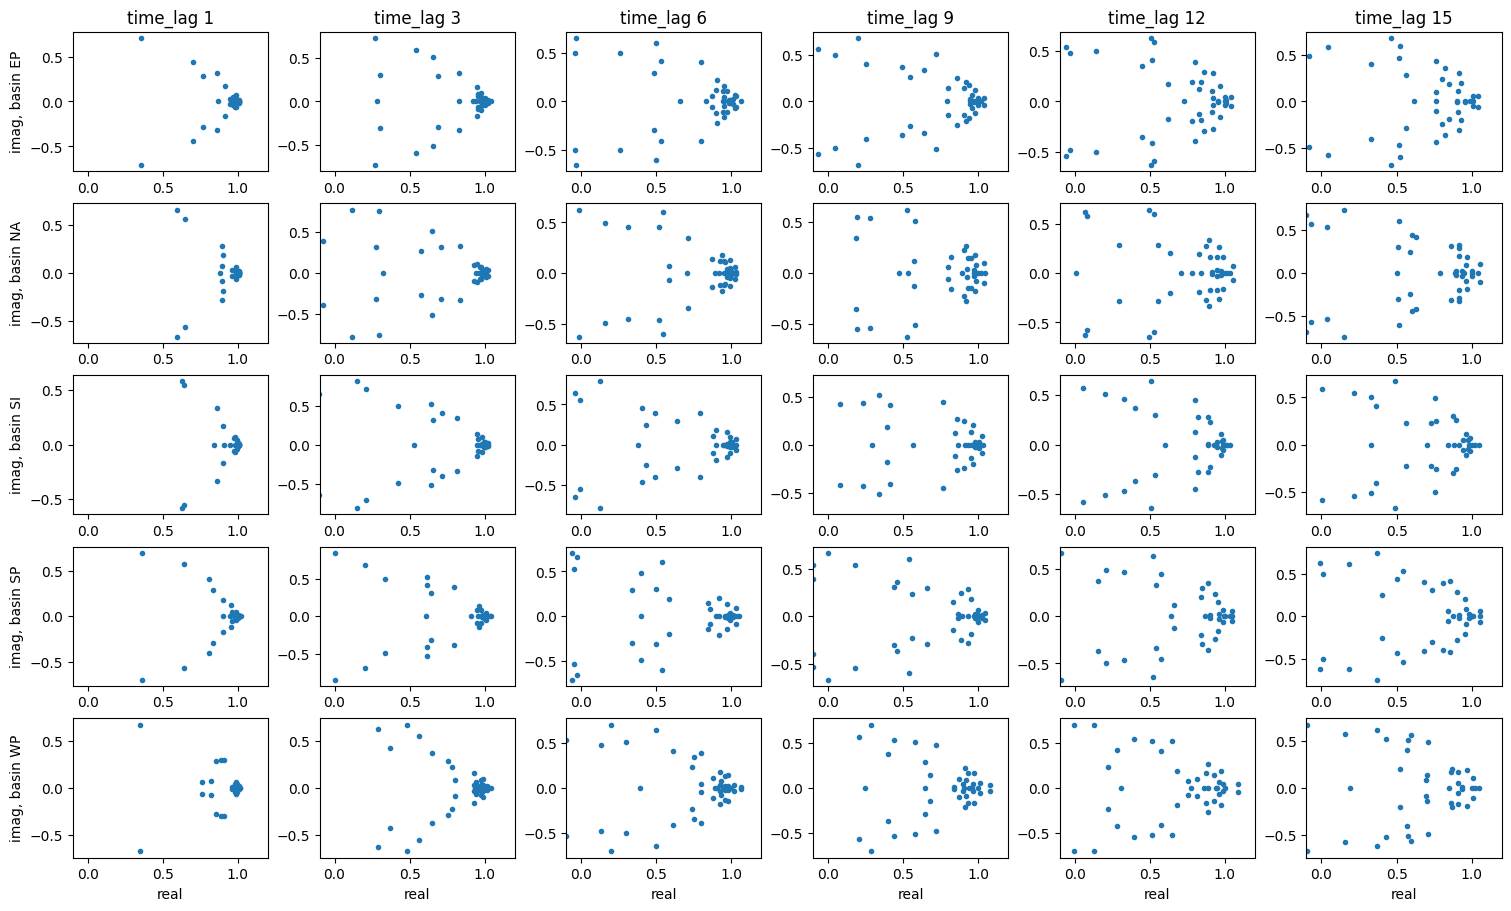

In [77]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 8

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


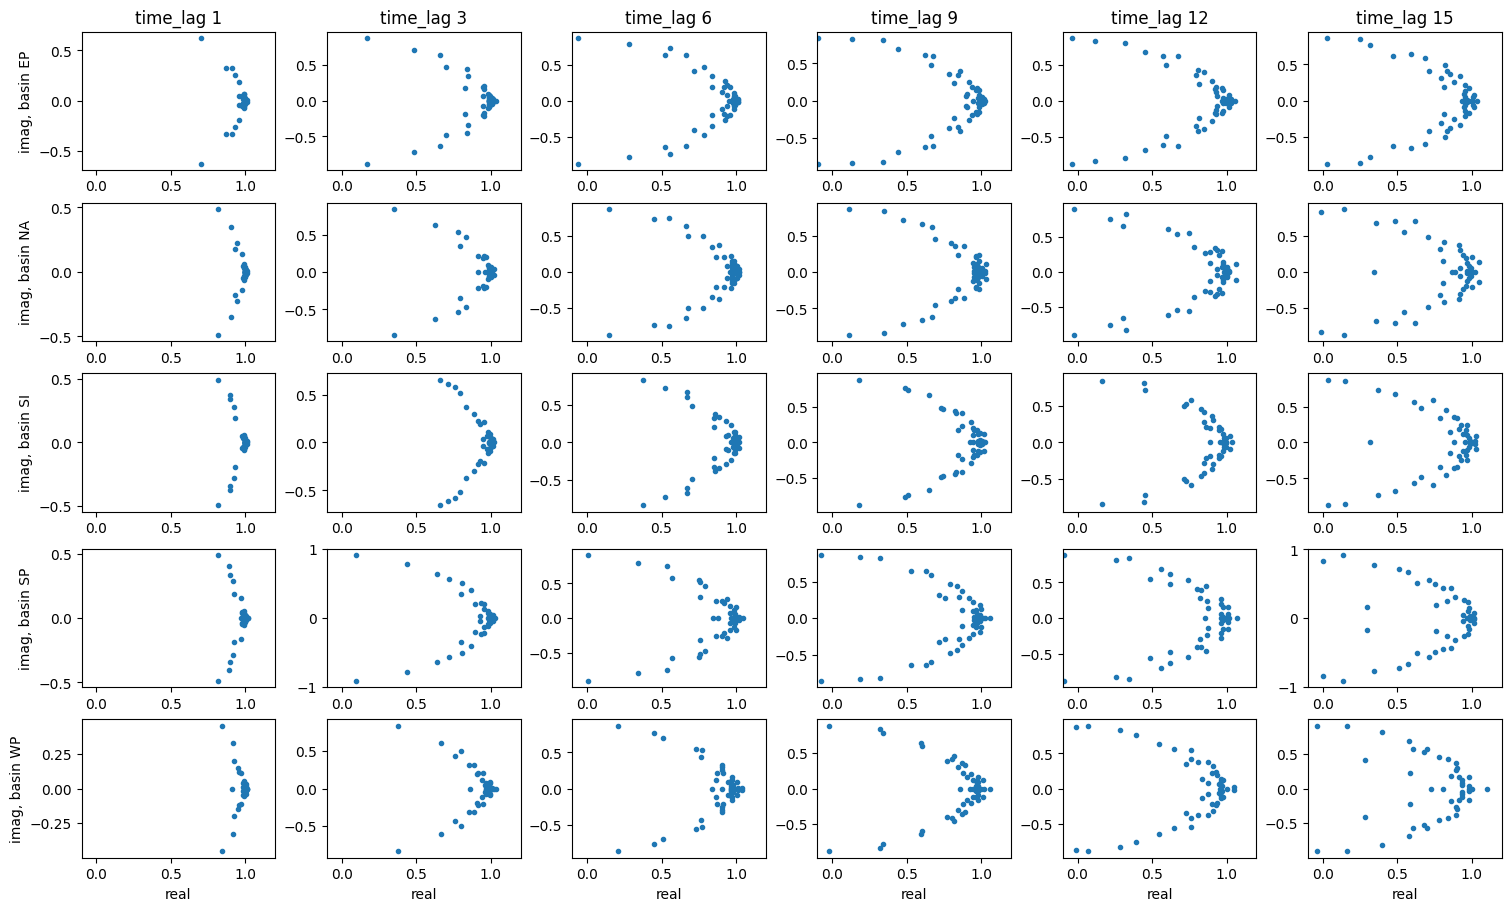

In [78]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 16

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


### Year range (2000, 2021)

Best time lag scaling for context length is 2 or 4. 4 gives slightly better RMSE. Best eigenvalue distribution for context length 8 or 16, with weakest "overshoot" over theoretical maximum of 1.

#### Num centers 800

In [53]:
year_range = (2000, 2021)
context_lengths = [2, 4, 8, 16]
num_centers = 800

In [54]:
time_step_h = 1.0
time_step_scaling = int(3 / time_step_h)
time_lags = [1, *list(np.array(range(1, 6, 1)) * time_step_scaling)]
evals, errors, time_scales = load_data(time_step_h, year_range, num_centers, context_lengths, time_lags)

time_step_h = 0.5
time_step_scaling = int(3 / time_step_h)
time_lags_05 = [1, *list(np.array(range(1, 6, 1)) * time_step_scaling)]
evals_05, errors_05, time_scales_05 = load_data(time_step_h, year_range, num_centers, context_lengths, time_lags_05)

Load data for context length: 2
Load data for context length: 4
Load data for context length: 8
Load data for context length: 16
Load data for context length: 2
Load data for context length: 4
Load data for context length: 8
Load data for context length: 16


Text(0, 0.5, 'RMSE')

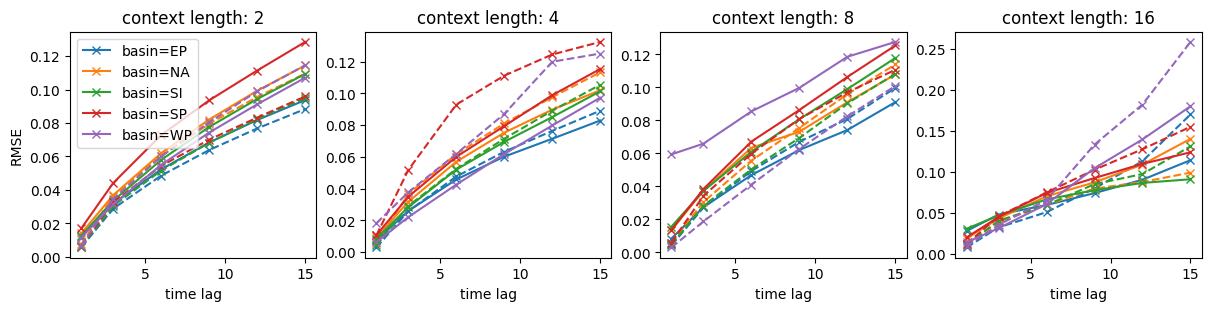

In [55]:
fig, ax = plt.subplots(nrows=1, ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,3)

for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    ax[idx_cl].plot(time_lags, errors[context_length][basin].values(), color=f"C{idx_b}", marker="x", label=f"basin={basin}")
    ax[idx_cl].plot(time_lags, errors_05[context_length][basin].values(), color=f"C{idx_b}", marker="x", linestyle="dashed")
    ax[idx_cl].set_title(f"context length: {context_length}")
    ax[idx_cl].set_xlabel("time lag")
ax[0].legend()
ax[0].set_ylabel("RMSE")

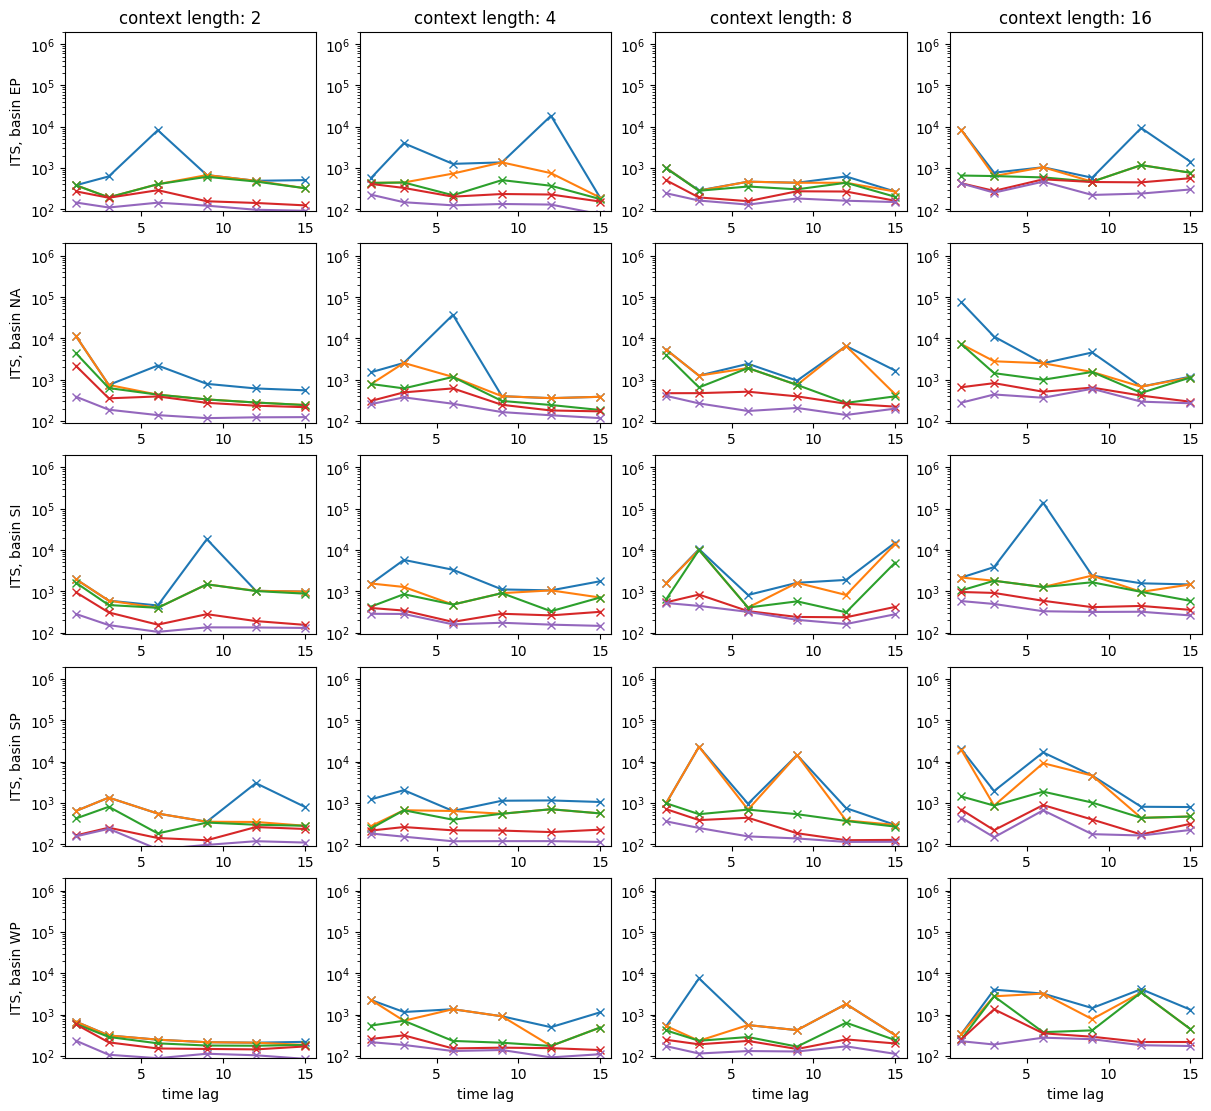

In [56]:
fig, ax = plt.subplots(nrows=len(basins), ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,11)

eval_range = [1, 2, 3, 5, 8]
for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    for idx_eval_c, idx_eval in enumerate(eval_range):
        ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", label=idx_eval)
        # ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales_05[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", linestyle="dashed")
    if idx_b == 0:
        ax[idx_b, idx_cl].set_title(f"context length: {context_length}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_cl].set_xlabel("time lag")
    ax[idx_b, idx_cl].set_yscale("log")
    ax[idx_b, idx_cl].set_ylim(9E1, 2E6)
    # ax[idx_b, 0].legend(title="eval index")
    ax[idx_b, 0].set_ylabel(f"ITS, basin {basin}")

##### Plotting eigenvalues

In [173]:
# fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
# fig.set_size_inches(15, 9)

# # context_length = 2
# for idx_cl, context_length in enumerate(context_lengths):

#     for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
#         ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".", color=f"C{idx_cl}", markersize=2)
#         if idx_tl == 0:
#             ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
#         if idx_b == 0:
#             ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
#         if idx_b == len(basins) - 1:
#             ax[idx_b, idx_tl].set_xlabel("real")
#         ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


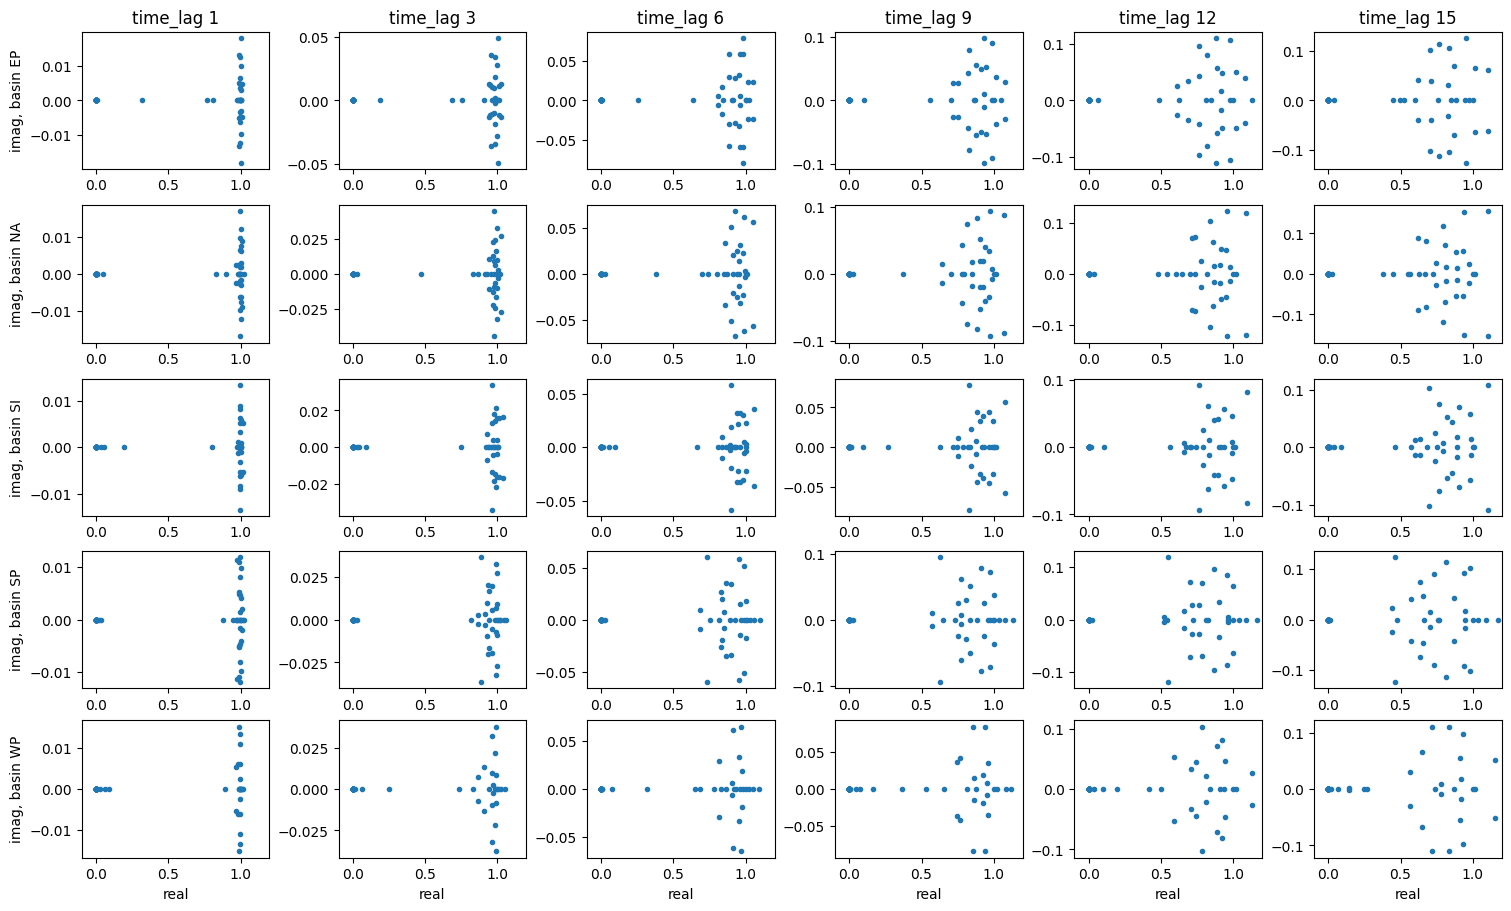

In [174]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 2

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


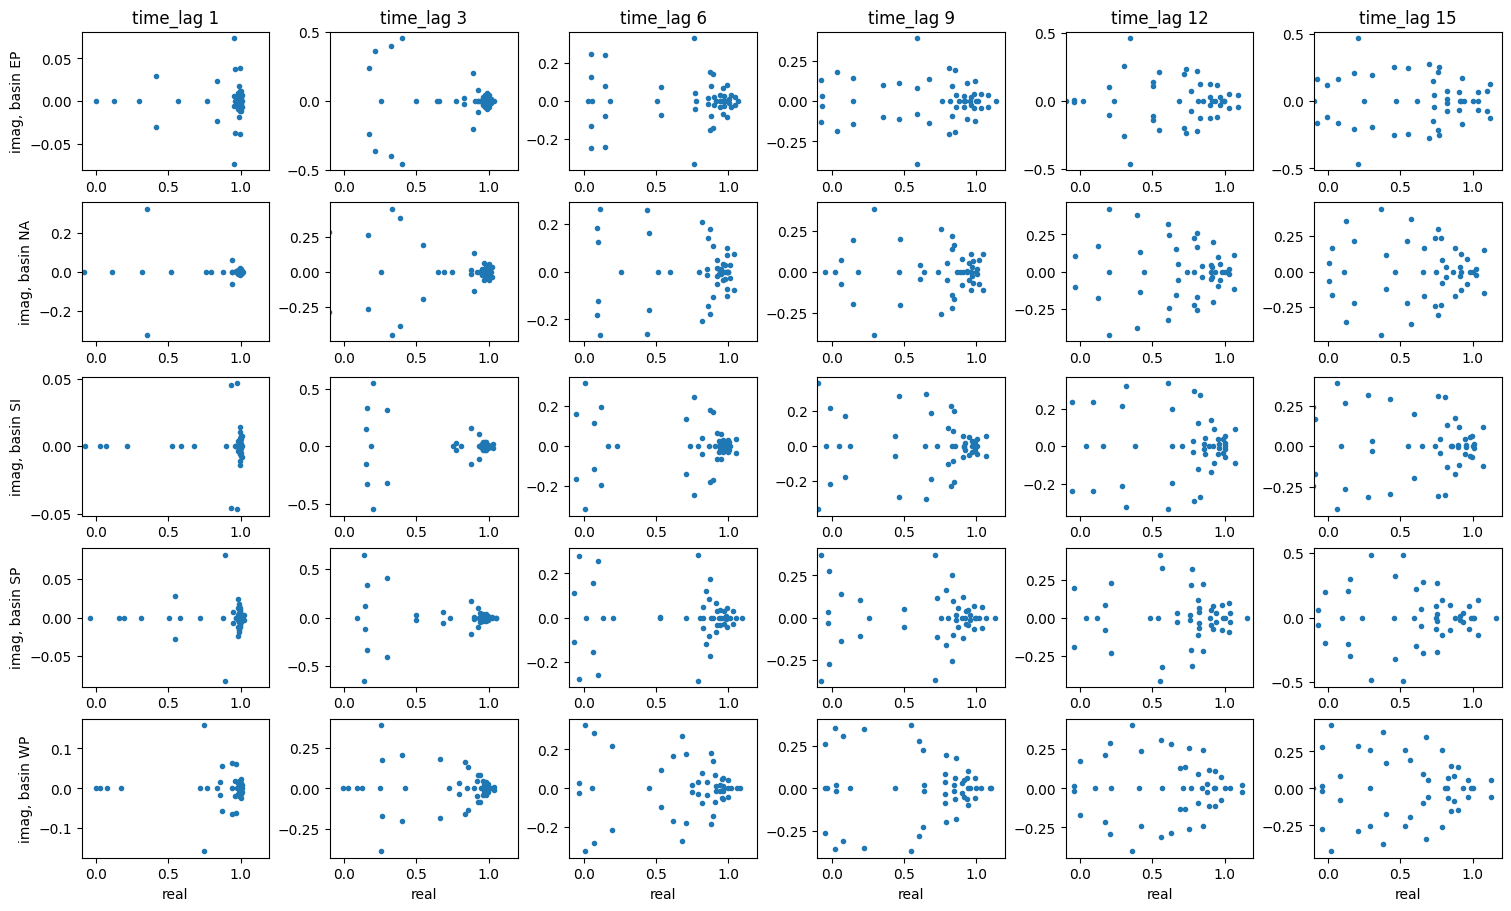

In [175]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 4

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


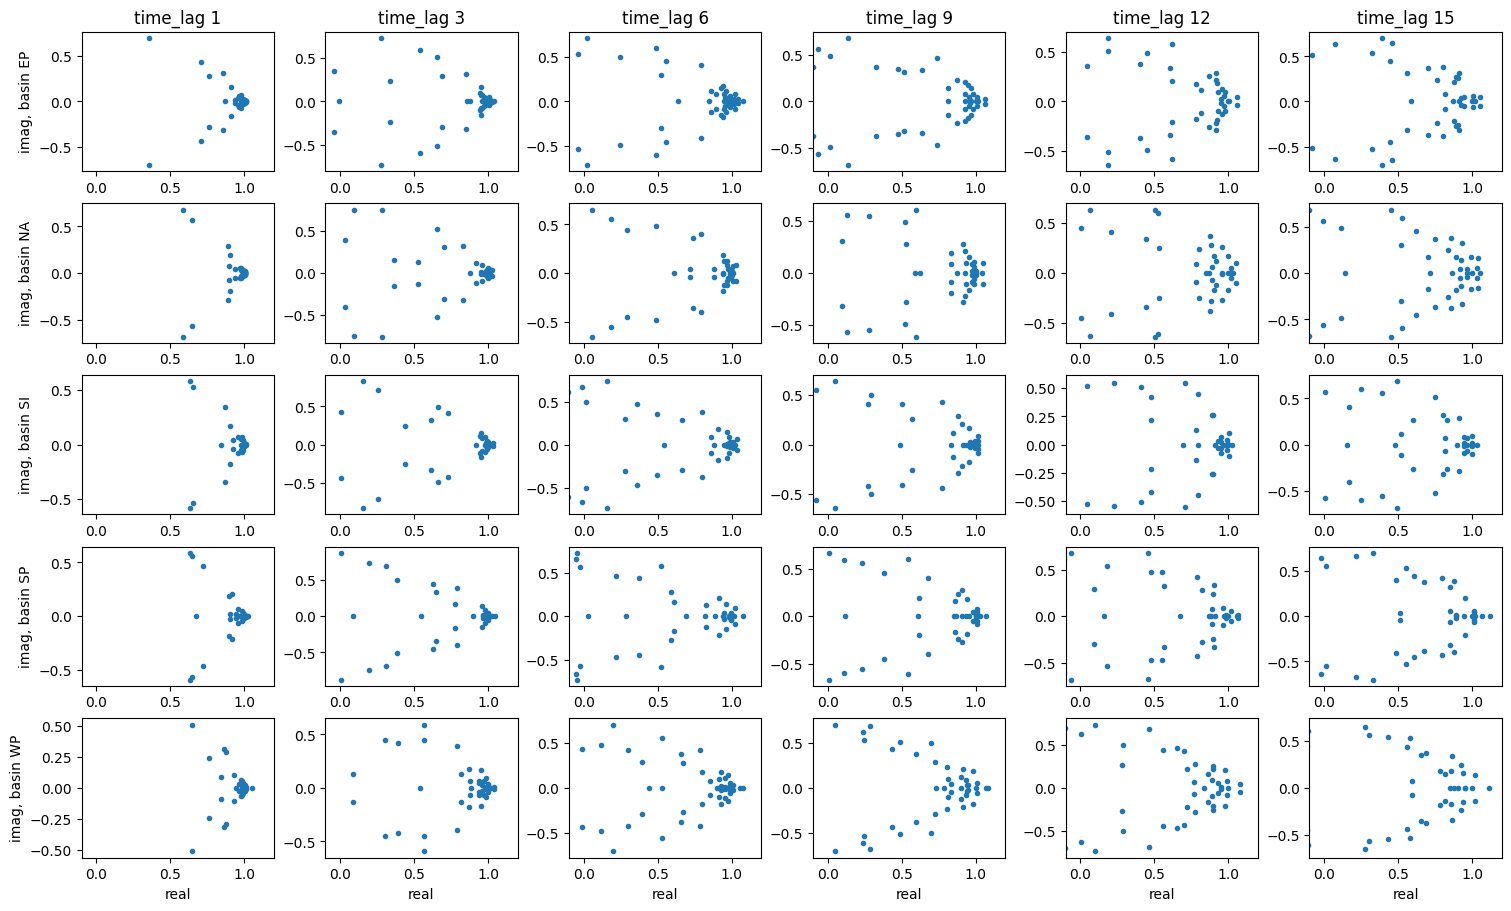

In [176]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 8

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


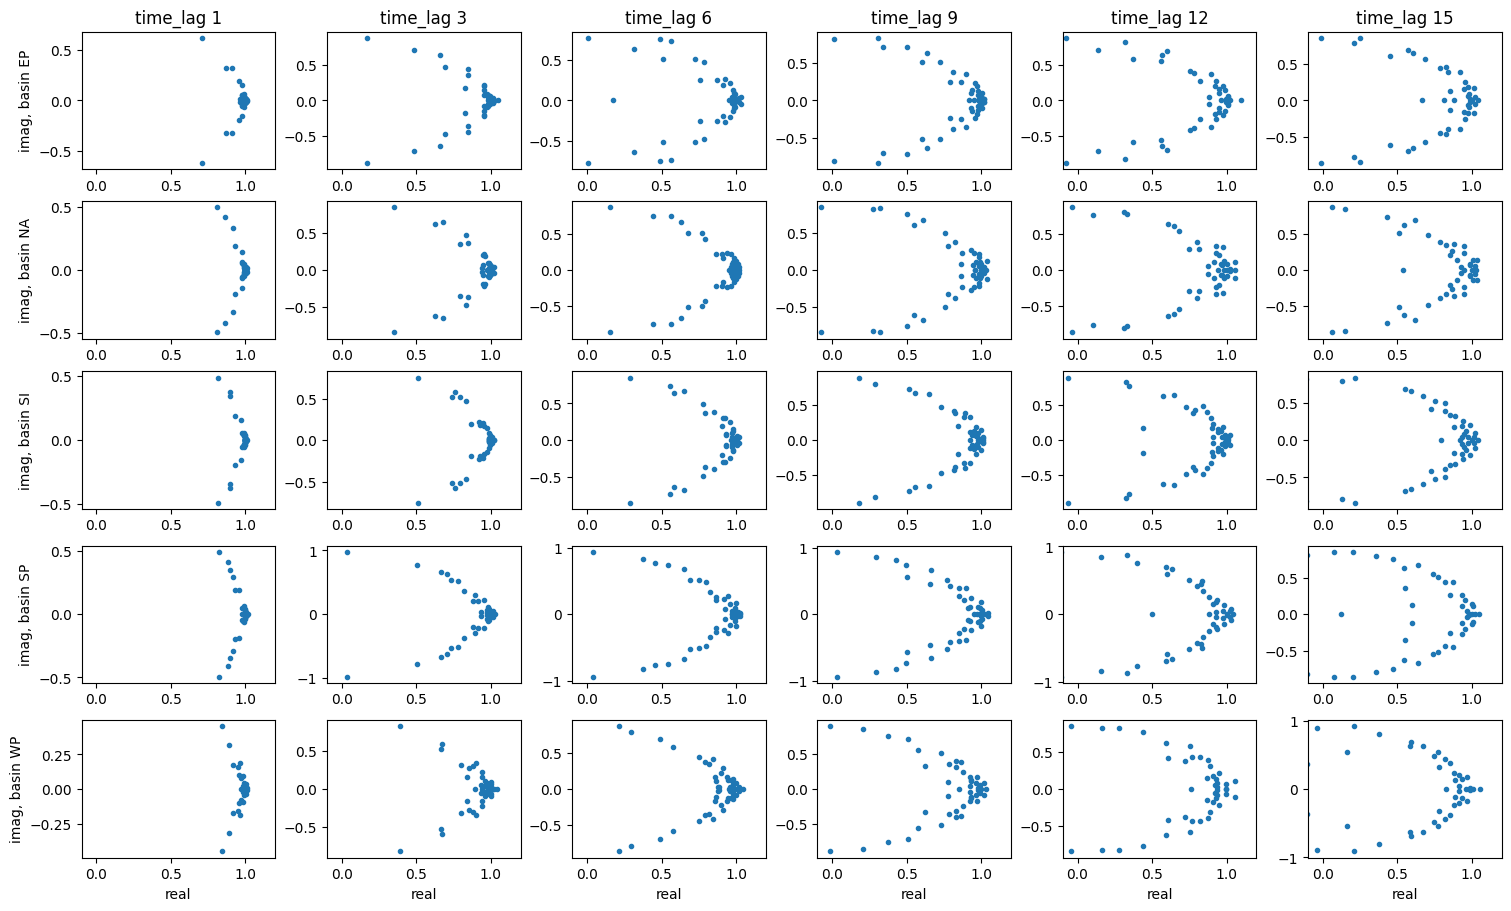

In [177]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 16

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


#### Num centers 1600

In [45]:
year_range = (2000, 2021)
context_lengths = [2, 4, 8, 16]
num_centers = 1600

In [46]:
time_step_h = 1.0
time_step_scaling = int(3 / time_step_h)
time_lags = [1, *list(np.array(range(1, 6, 1)) * time_step_scaling)]
evals, errors, time_scales = load_data(time_step_h, year_range, num_centers, context_lengths, time_lags)

time_step_h = 0.5
time_step_scaling = int(3 / time_step_h)
time_lags_05 = [1, *list(np.array(range(1, 6, 1)) * time_step_scaling)]
evals_05, errors_05, time_scales_05 = load_data(time_step_h, year_range, num_centers, context_lengths, time_lags_05)

Load data for context length: 2
Load data for context length: 4
Load data for context length: 8
Load data for context length: 16
Load data for context length: 2
Load data for context length: 4
Load data for context length: 8
Load data for context length: 16


Text(0, 0.5, 'RMSE')

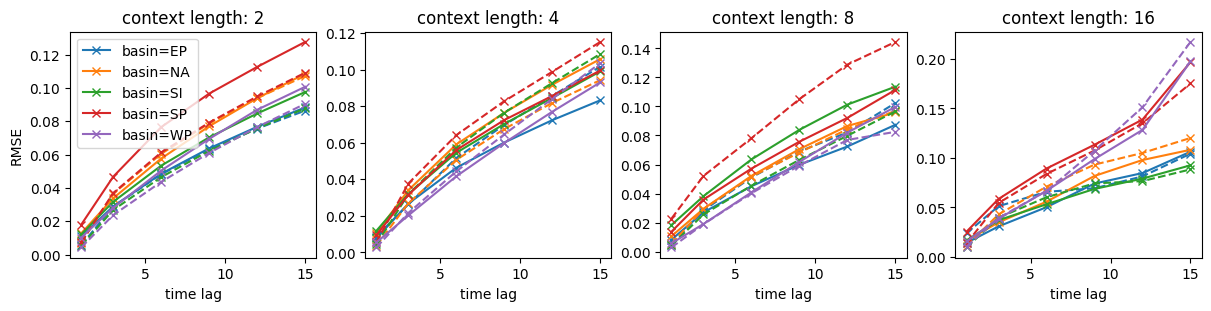

In [47]:
fig, ax = plt.subplots(nrows=1, ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,3)

for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    ax[idx_cl].plot(time_lags, errors[context_length][basin].values(), color=f"C{idx_b}", marker="x", label=f"basin={basin}")
    ax[idx_cl].plot(time_lags, errors_05[context_length][basin].values(), color=f"C{idx_b}", marker="x", linestyle="dashed")
    ax[idx_cl].set_title(f"context length: {context_length}")
    ax[idx_cl].set_xlabel("time lag")
ax[0].legend()
ax[0].set_ylabel("RMSE")

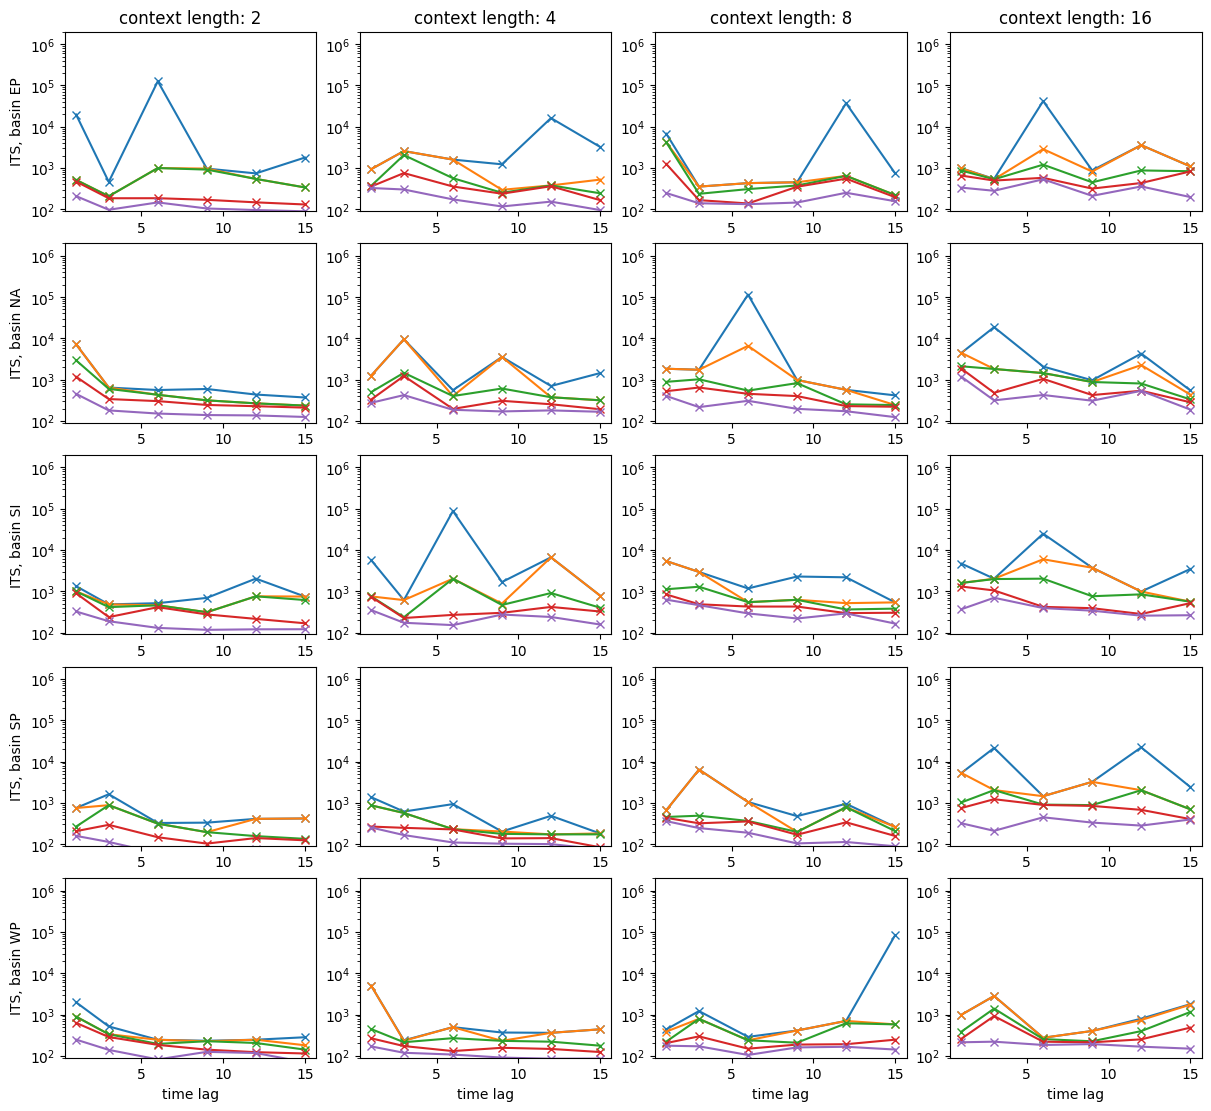

In [48]:
fig, ax = plt.subplots(nrows=len(basins), ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,11)

eval_range = [1, 2, 3, 5, 8]
for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    for idx_eval_c, idx_eval in enumerate(eval_range):
        ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", label=idx_eval)
        # ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales_05[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", linestyle="dashed")
    if idx_b == 0:
        ax[idx_b, idx_cl].set_title(f"context length: {context_length}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_cl].set_xlabel("time lag")
    ax[idx_b, idx_cl].set_yscale("log")
    ax[idx_b, idx_cl].set_ylim(9E1, 2E6)
    # ax[idx_b, 0].legend(title="eval index")
    ax[idx_b, 0].set_ylabel(f"ITS, basin {basin}")



##### Plotting eigenvalues

In [182]:
# fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
# fig.set_size_inches(15, 9)

# # context_length = 2
# for idx_cl, context_length in enumerate(context_lengths):

#     for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
#         ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".", color=f"C{idx_cl}", markersize=2)
#         if idx_tl == 0:
#             ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
#         if idx_b == 0:
#             ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
#         if idx_b == len(basins) - 1:
#             ax[idx_b, idx_tl].set_xlabel("real")
#         ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


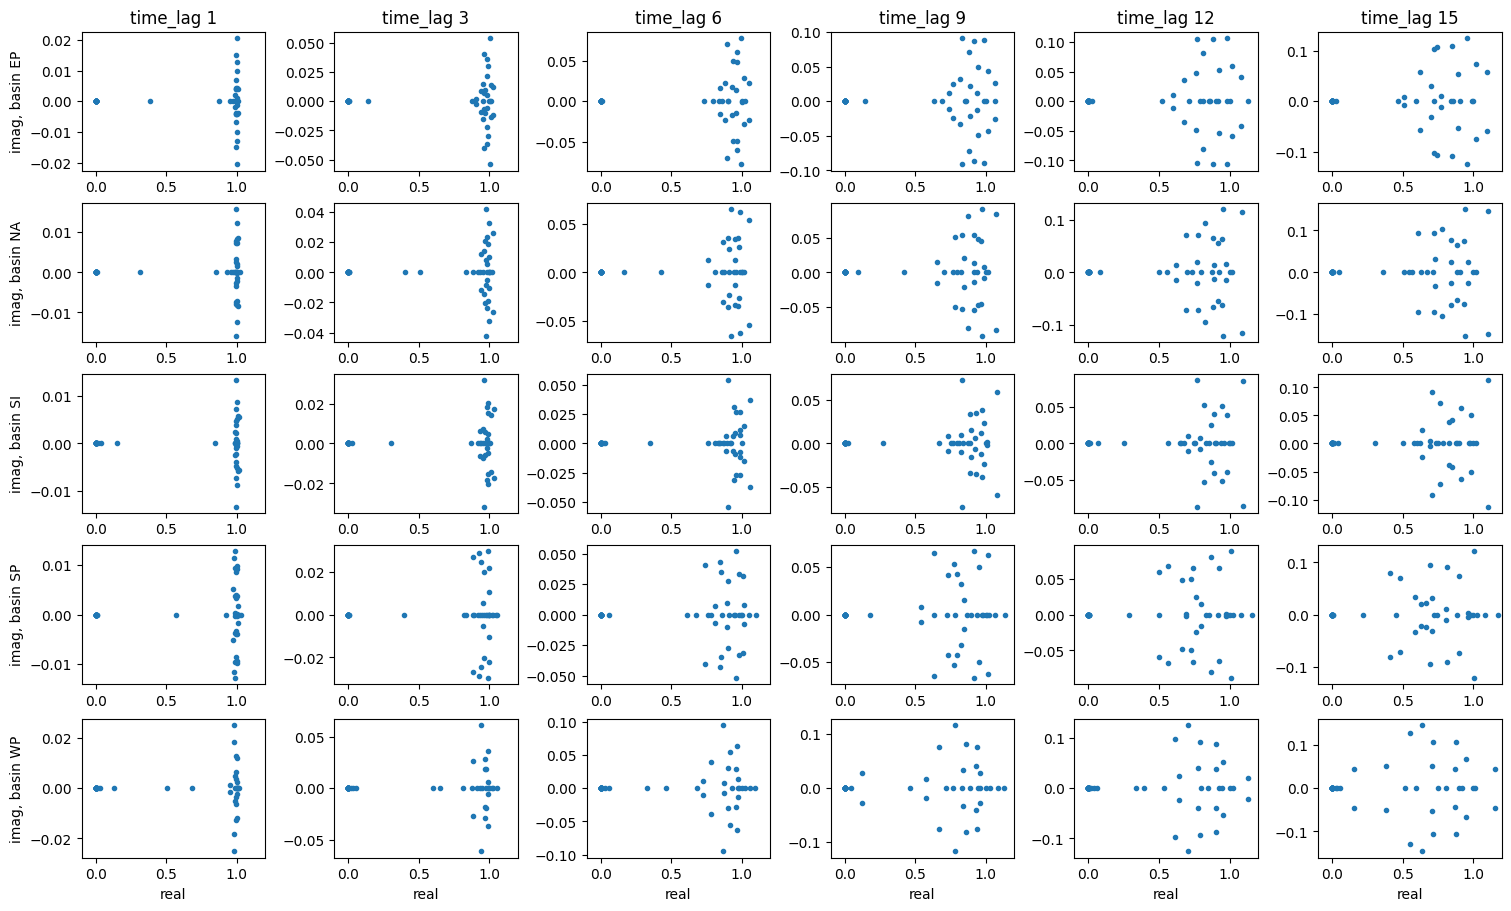

In [183]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 2

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


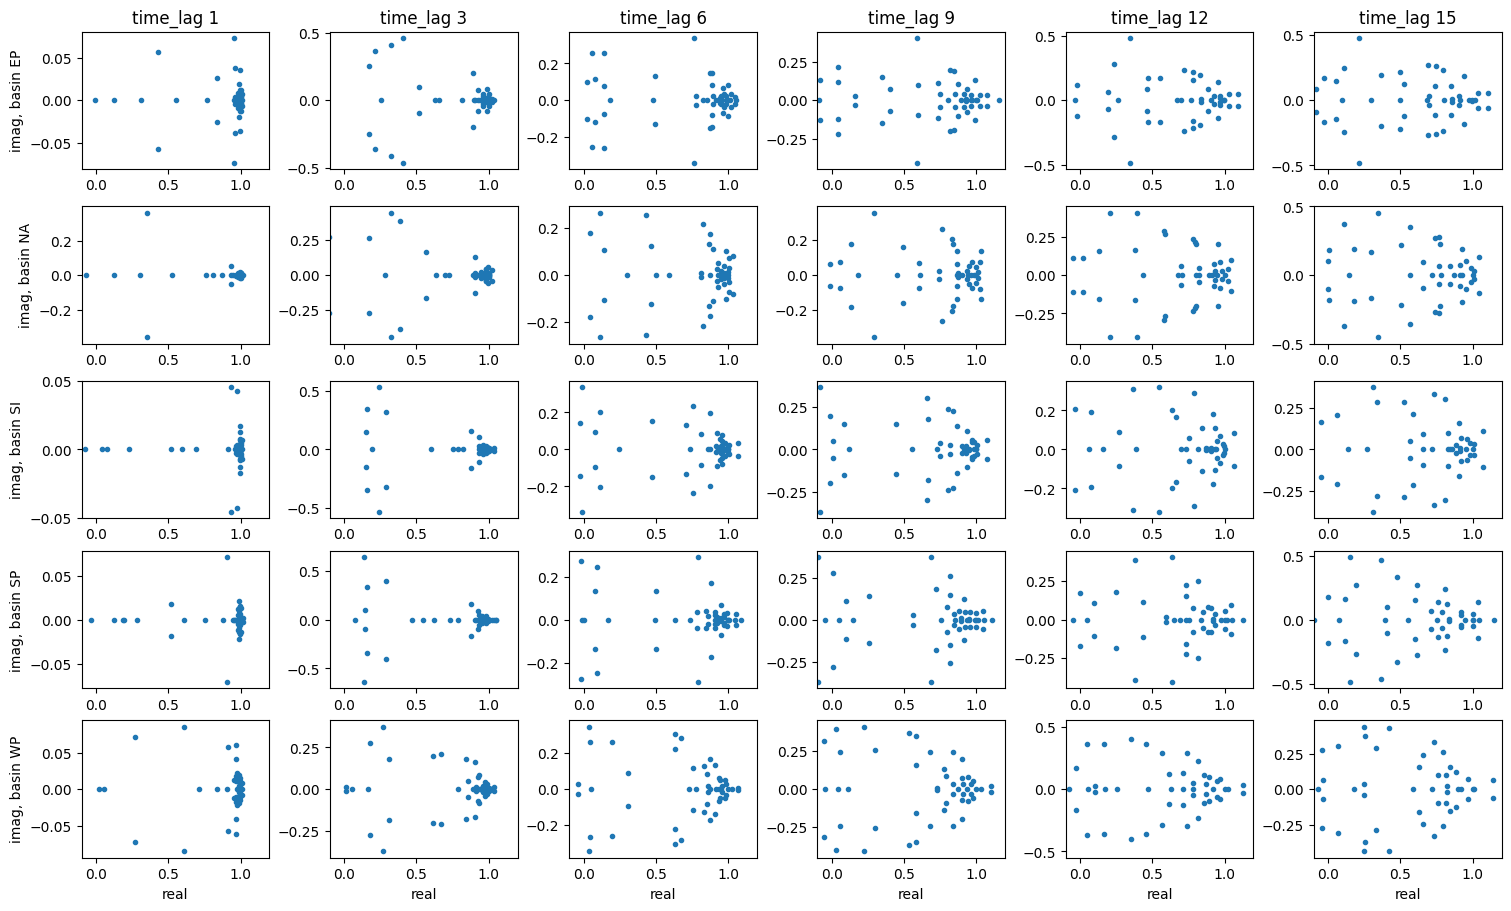

In [184]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 4

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


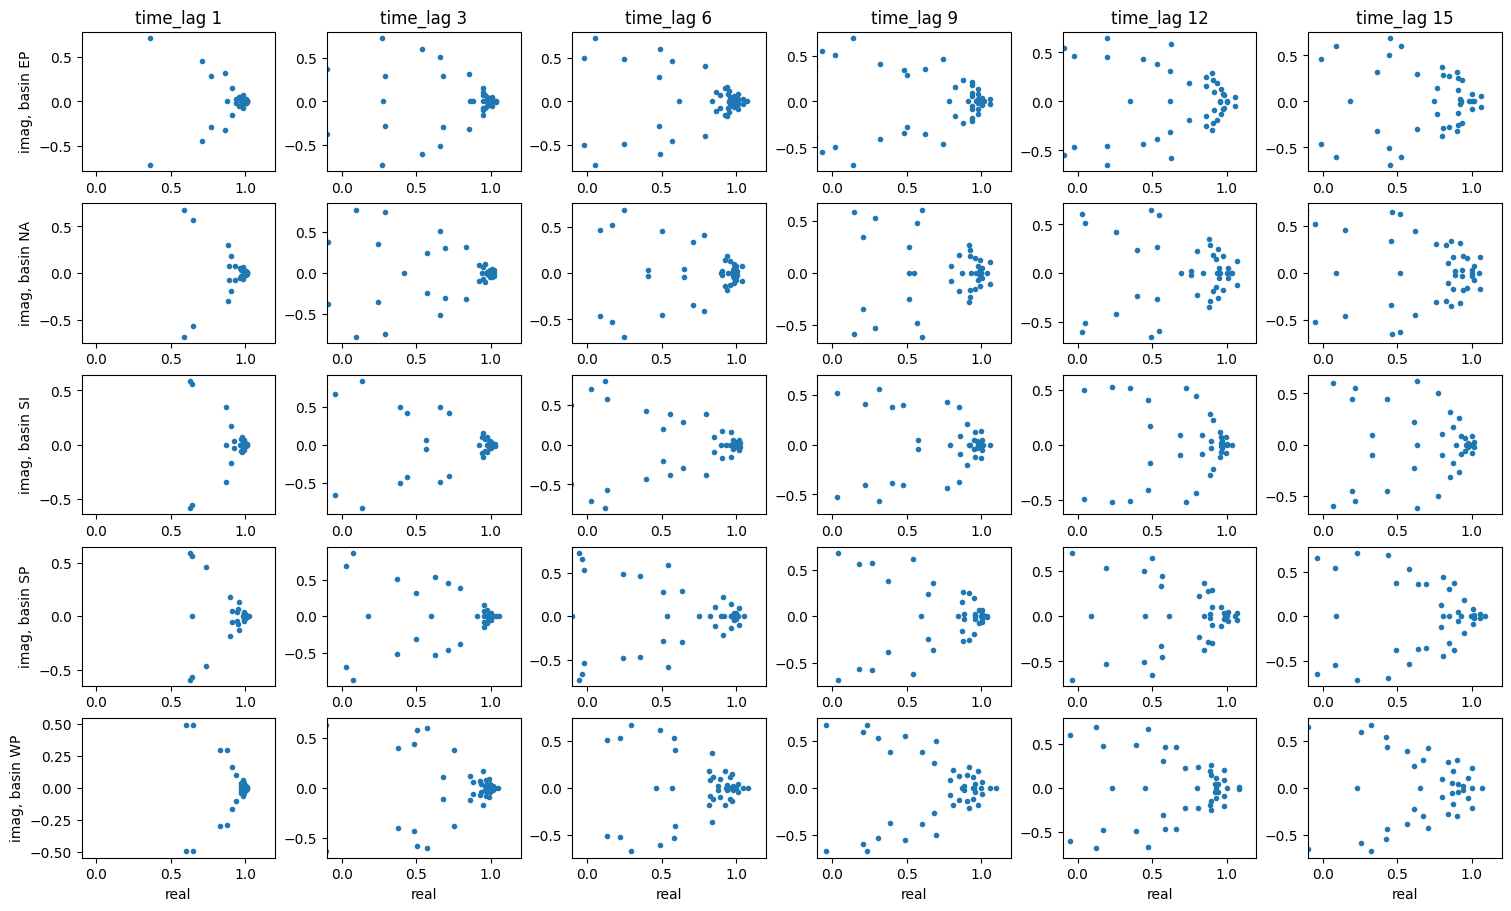

In [185]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 8

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)


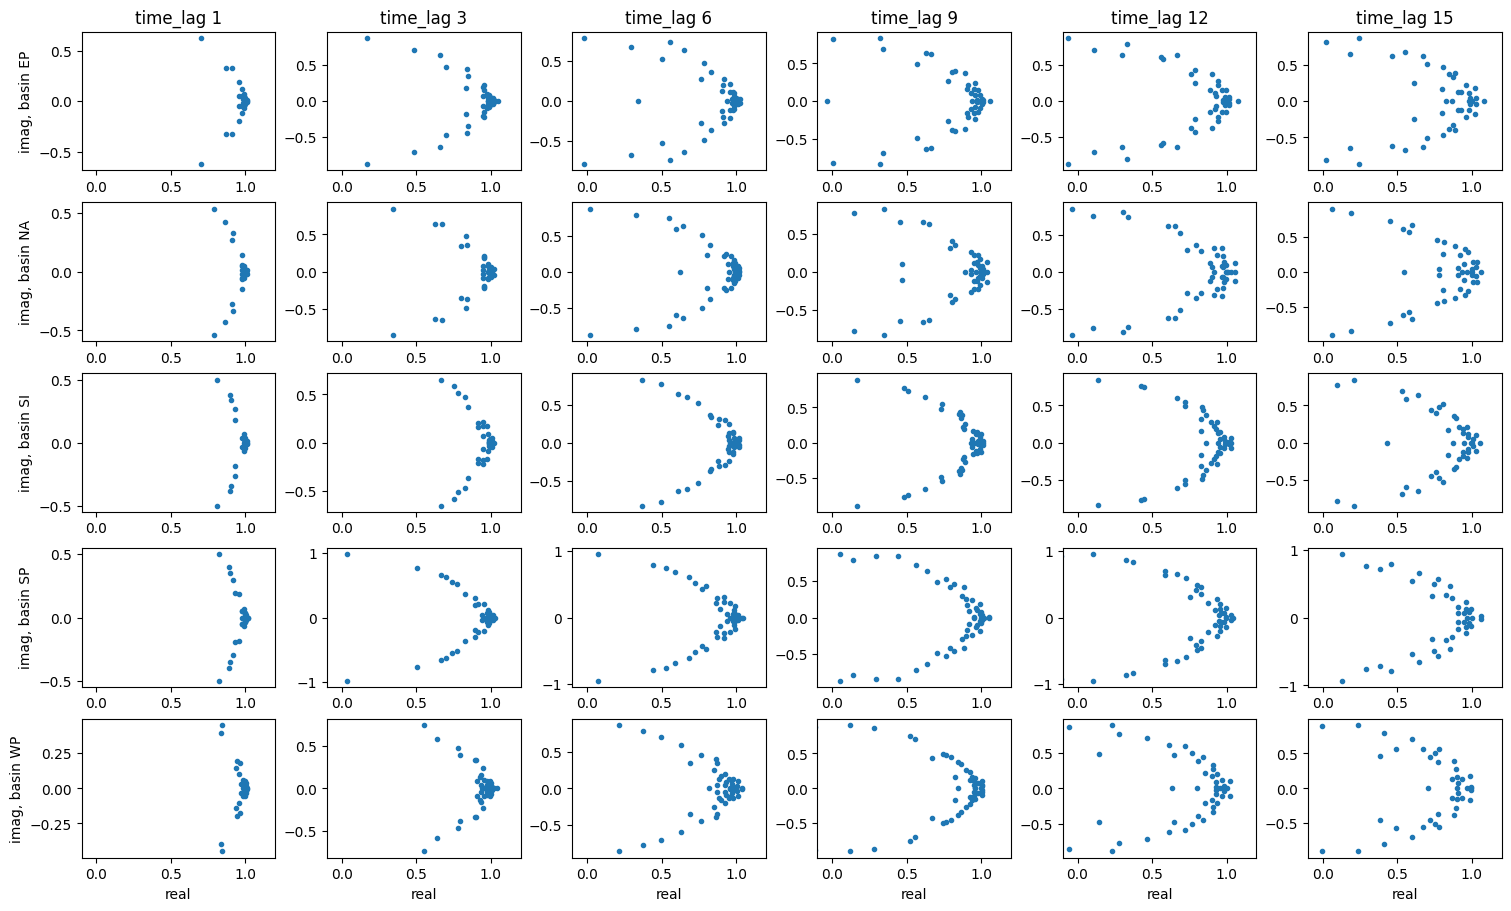

In [186]:
fig, ax = plt.subplots(nrows=len(basins), ncols=len(time_lags), constrained_layout=True)
fig.set_size_inches(15, 9)

context_length = 16

for (idx_b, basin), (idx_tl, time_lag) in product(enumerate(basins), enumerate(time_lags)):
    ax[idx_b, idx_tl].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, ".")
    if idx_tl == 0:
        ax[idx_b, idx_tl].set_ylabel(f"imag, basin {basin}")
    if idx_b == 0:
        ax[idx_b, idx_tl].set_title(f"time_lag {time_lag}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_tl].set_xlabel("real")
    ax[idx_b, idx_tl].set_xlim(-0.1, 1.2)
